<a href="https://colab.research.google.com/github/BotSonu/Fabric-Community-Notebook-Challenge-The-Cities-of-Tomorrow-Urban-Growth-Sustainability/blob/main/Nov2025_SreyaMondal_CitiesOfTomorrow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Cities of Tomorrow: Urban Sustainability Modeling Notebook**

In [1]:
# %% ------------------ (0) IMPORTS ------------------
import os
import sys
import math
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

try:
    import plotly.express as px
    PLOTLY_AVAILABLE = True
except:
    PLOTLY_AVAILABLE = False

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

try:
    import shap
    SHAP_AVAILABLE = True
except:
    SHAP_AVAILABLE = False

pd.set_option("display.max_columns", 200)
rcParams["figure.figsize"] = (10, 6)
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
# %% ------------------ (1) CONFIG ------------------

DATA_PATH = "/content/urban_planning_dataset.csv"

OUTPUT_DIR = "/content/outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Using dataset path:", DATA_PATH)

Using dataset path: /content/urban_planning_dataset.csv


In [3]:
# %% ------------------ (2) LOAD + CHECK ------------------
df = pd.read_csv(DATA_PATH, sep=None, engine="python")
print("Shape:", df.shape)

print("\nColumns:")
print(df.columns.tolist())

print("\nFirst 5 rows:")
print(df.head())

df.head(20).to_csv(f"{OUTPUT_DIR}/sample_preview.csv", index=False)

# ------------------ EMPTY DATASET CHECK ------------------
if df.shape[0] == 0:
    raise ValueError("❌ ERROR: CSV contains column headers but **0 rows** of data. Upload a non-empty dataset.")

Shape: (3476, 16)

Columns:
['building_density', 'road_connectivity', 'public_transport_access', 'air_quality_index', 'green_cover_percentage', 'carbon_footprint', 'population_density', 'crime_rate', 'avg_income', 'renewable_energy_usage', 'disaster_risk_index', 'land_use_type_Commercial', 'land_use_type_Green Space', 'land_use_type_Industrial', 'land_use_type_Residential', 'urban_sustainability_score']

First 5 rows:
   building_density  road_connectivity  public_transport_access  \
0          0.367915           0.393821                 0.428129   
1          0.414306           0.608445                 0.658481   
2          0.827902           0.444679                 0.263853   
3          0.733936           0.742708                 0.012022   
4          0.769643           0.228268                 0.519082   

   air_quality_index  green_cover_percentage  carbon_footprint  \
0           0.414830                0.238555          0.921950   
1           0.490982                0.91768

🔍 Running Data Visualization...


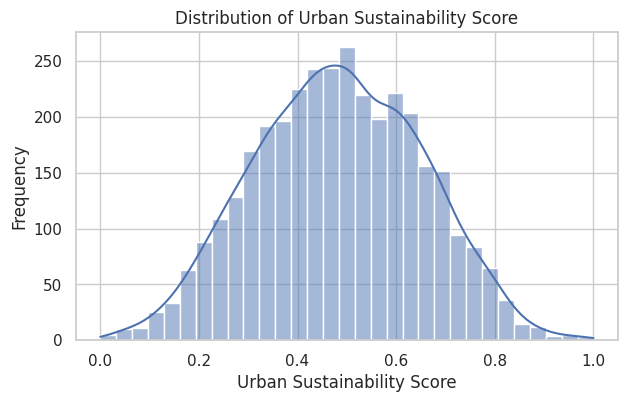

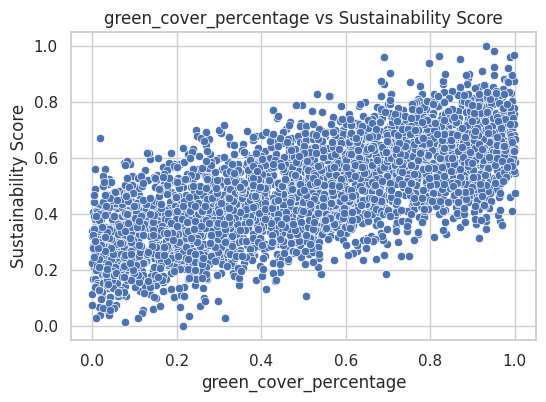

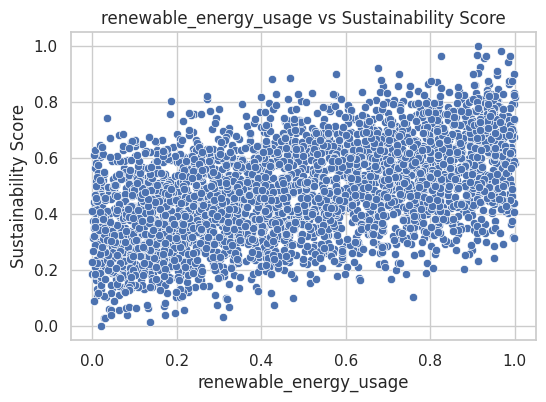

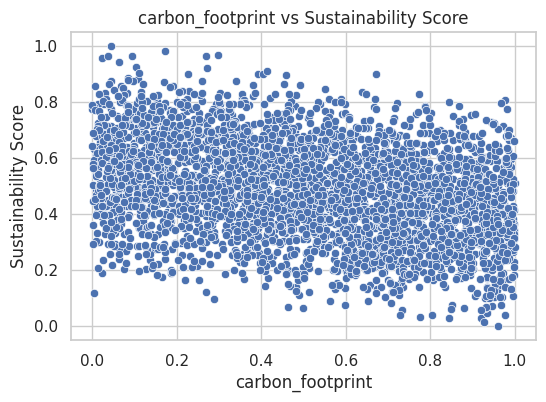

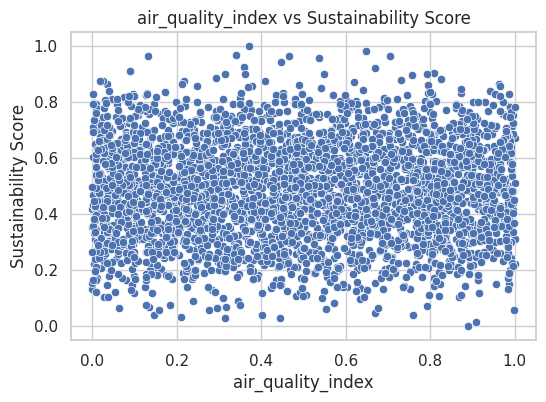

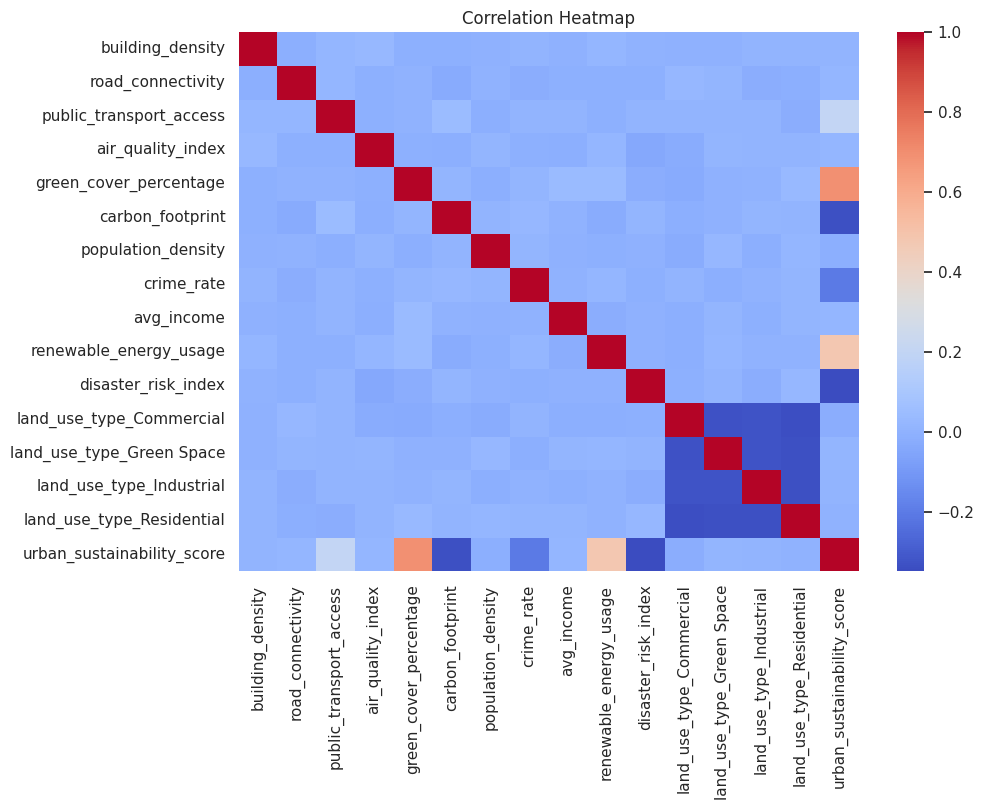

📊 Visualization completed.


In [4]:
# %% ------------------ (3) DATA VISUALIZATION ------------------

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

print("🔍 Running Data Visualization...")

target = "urban_sustainability_score"

# 1️⃣ Distribution of urban sustainability score
plt.figure(figsize=(7, 4))
sns.histplot(df[target], kde=True)
plt.title('Distribution of Urban Sustainability Score')
plt.xlabel('Urban Sustainability Score')
plt.ylabel('Frequency')
plt.show()

# 2️⃣ Top 10 cities / zones by mean sustainability score (if a city column exists)
city_col = None
for col in df.columns:
    if "city" in col.lower() or "zone" in col.lower() or "region" in col.lower():
        city_col = col
        break

if city_col:
    plt.figure(figsize=(10, 4))
    top_groups = df.groupby(city_col)[target].mean().sort_values(ascending=False).head(10)
    sns.barplot(x=top_groups.index, y=top_groups.values)
    plt.title(f"Top 10 {city_col} by Sustainability Score")
    plt.xlabel(city_col)
    plt.ylabel("Avg Sustainability Score")
    plt.xticks(rotation=45)
    plt.show()

# 3️⃣ Relationship of important numeric features with target
important_features = [
    "green_cover_percentage",
    "renewable_energy_usage",
    "carbon_footprint",
    "air_quality_index"
]

for feat in important_features:
    if feat in df.columns:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=df[feat], y=df[target])
        plt.title(f"{feat} vs Sustainability Score")
        plt.xlabel(feat)
        plt.ylabel("Sustainability Score")
        plt.show()

# 4️⃣ Correlation heatmap
numeric_cols = df.select_dtypes(include="number").columns
plt.figure(figsize=(10, 7))
sns.heatmap(df[numeric_cols].corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

print("📊 Visualization completed.")


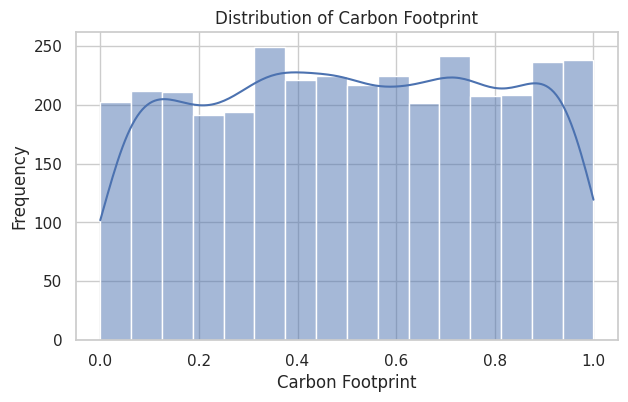

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 4))
sns.histplot(df['carbon_footprint'], kde=True)
plt.title('Distribution of Carbon Footprint')
plt.xlabel('Carbon Footprint')
plt.ylabel('Frequency')
plt.show()

In [6]:
# %% ------------------ (4) COLUMN CANONICALIZATION ------------------
EXPECTED_COLS = {
    'city': ['city','City','Town'],
    'country': ['country','Country'],
    'year': ['year','Year'],
    'population': ['population','pop', 'population_density'],
    'area_km2': ['area_km2','area'],
    'green_area_km2': ['green_area_km2','green_area', 'green_cover_percentage'],
    'gdp_per_capita': ['gdp_per_capita','gdp'],
    'co2_emissions': ['co2_emissions','co2', 'carbon_footprint'],
    'sustainability_index': ['sustainability_index','sustainability_score', 'urban_sustainability_score']
}

COLUMN_MAP = {}
cols = df.columns.tolist()

def best_col(choices, cols):
    for c in choices:
        if c in cols:
            return c
    low = {x.lower(): x for x in cols}
    for c in choices:
        if c.lower() in low:
            return low[c.lower()]
    return None

for canon, choices in EXPECTED_COLS.items():
    found = best_col(choices, cols)
    if found:
        COLUMN_MAP[canon] = found

print("\nAuto-Mapped Columns:")
for k,v in COLUMN_MAP.items():
    print(f"  {k} -> {v}")


Auto-Mapped Columns:
  population -> population_density
  green_area_km2 -> green_cover_percentage
  co2_emissions -> carbon_footprint
  sustainability_index -> urban_sustainability_score


In [7]:
# %% ------------------ (5) CREATE CANONICAL COLUMNS ------------------
for canon, col in COLUMN_MAP.items():
    df[canon] = df[col]

num_candidates = [
    "population","area_km2","green_area_km2","gdp_per_capita",
    "co2_emissions","sustainability_index","year"
]

for c in num_candidates:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

print("\nCanonical columns present now:")
print([c for c in df.columns if c in COLUMN_MAP])



Canonical columns present now:
['population', 'green_area_km2', 'co2_emissions', 'sustainability_index']


In [8]:
# %% ------------------ (6) CLEANING ------------------
missing = df.isna().mean().sort_values(ascending=False)
print("\nMissing proportions:")
print(missing)

high_missing = missing[missing > 0.90].index.tolist()
if high_missing:
    df.drop(columns=high_missing, inplace=True, errors="ignore")

KEY_VARS = ["city","country"]
for k in KEY_VARS:
    if k in df.columns:
        df = df[df[k].notna()]

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if numeric_cols:
    df[numeric_cols] = SimpleImputer(strategy="median").fit_transform(df[numeric_cols])

print("\nMissing after cleaning:")
print(df.isna().sum()[df.isna().sum() > 0])



Missing proportions:
building_density              0.0
road_connectivity             0.0
public_transport_access       0.0
air_quality_index             0.0
green_cover_percentage        0.0
carbon_footprint              0.0
population_density            0.0
crime_rate                    0.0
avg_income                    0.0
renewable_energy_usage        0.0
disaster_risk_index           0.0
land_use_type_Commercial      0.0
land_use_type_Green Space     0.0
land_use_type_Industrial      0.0
land_use_type_Residential     0.0
urban_sustainability_score    0.0
population                    0.0
green_area_km2                0.0
co2_emissions                 0.0
sustainability_index          0.0
dtype: float64

Missing after cleaning:
Series([], dtype: int64)


In [9]:
# %% ------------------ (7) FEATURE ENGINEERING ------------------
if "population" in df.columns and "area_km2" in df.columns:
    df["pop_density_per_km2"] = df["population"] / df["area_km2"]

if "green_area_km2" in df.columns and "population" in df.columns:
    df["green_area_m2"] = df["green_area_km2"] * 1_000_000
    df["green_m2_per_person"] = df["green_area_m2"] / df["population"]

if "sustainability_index" not in df.columns:
    synth = {}
    if "gdp_per_capita" in df.columns:
        synth["gdp"] = (df["gdp_per_capita"] - df["gdp_per_capita"].min()) / (df["gdp_per_capita"].ptp()+1e-9)
    if "co2_emissions" in df.columns:
        synth["co2"] = 1 - ((df["co2_emissions"] - df["co2_emissions"].min()) / (df["co2_emissions"].ptp()+1e-9))
    if "green_m2_per_person" in df.columns:
        synth["green"] = (df["green_m2_per_person"] - df["green_m2_per_person"].min()) / (df["green_m2_per_person"].ptp()+1e-9)

    if synth:
        df["sustainability_index"] = pd.DataFrame(synth).mean(axis=1)

# final impute
eng_nums = df.select_dtypes(include=[np.number]).columns
# Replace inf values with NaN before imputation
df[eng_nums] = df[eng_nums].replace([np.inf, -np.inf], np.nan)
df[eng_nums] = SimpleImputer(strategy="median").fit_transform(df[eng_nums])


Summary Stats:
                              count          mean           std  min  \
building_density            3476.0  4.963454e-01  2.877704e-01  0.0   
road_connectivity           3476.0  4.902049e-01  2.874836e-01  0.0   
public_transport_access     3476.0  5.013972e-01  2.871627e-01  0.0   
air_quality_index           3476.0  4.944446e-01  2.871852e-01  0.0   
green_cover_percentage      3476.0  5.055790e-01  2.883946e-01  0.0   
carbon_footprint            3476.0  5.096573e-01  2.881386e-01  0.0   
population_density          3476.0  5.021580e-01  2.869118e-01  0.0   
crime_rate                  3476.0  4.996592e-01  2.845527e-01  0.0   
avg_income                  3476.0  4.915557e-01  2.854841e-01  0.0   
renewable_energy_usage      3476.0  4.998808e-01  2.901456e-01  0.0   
disaster_risk_index         3476.0  4.940025e-01  2.877195e-01  0.0   
land_use_type_Commercial    3476.0  2.523015e-01  4.343958e-01  0.0   
land_use_type_Green Space   3476.0  2.468354e-01  4.312322e-

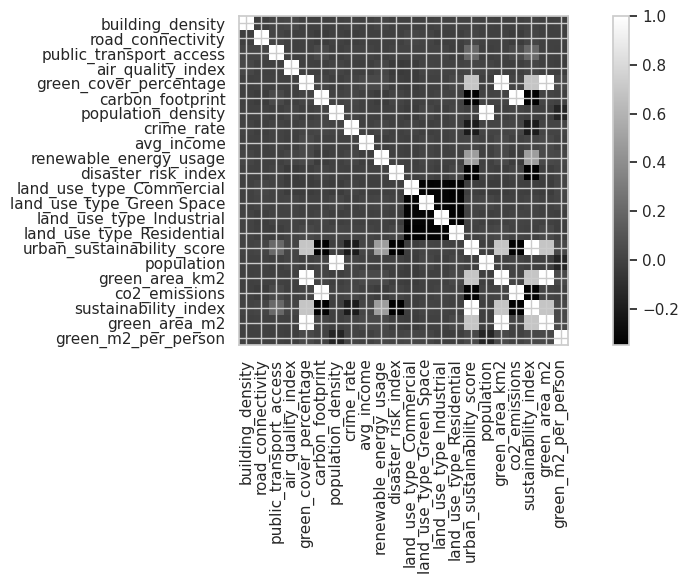

In [10]:
# %% ------------------ (8) EDA ------------------
print("\nSummary Stats:\n", df.describe().T)

if "population" in df.columns:
    tops = df.sort_values("population", ascending=False).head(10)
    tops.to_csv(f"{OUTPUT_DIR}/top10_population.csv", index=False)

if "pop_density_per_km2" in df.columns and "sustainability_index" in df.columns:
    plt.scatter(df["pop_density_per_km2"], df["sustainability_index"], alpha=0.5)
    plt.xscale("log")
    plt.xlabel("Population Density (log)")
    plt.ylabel("Sustainability")
    plt.title("Density vs Sustainability")
    plt.savefig(f"{OUTPUT_DIR}/density_vs_sustainability.png")
    plt.show()

# correlation
num_cols = df.select_dtypes(include=[np.number]).columns
if len(num_cols) >= 3:
    corr = df[num_cols].corr()
    plt.imshow(corr, cmap="gray", interpolation="none")
    plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/correlation_matrix.png")
    plt.show()

In [11]:
# %% ------------------ (9) MODEL TRAINING ------------------
TARGET = "urban_sustainability_score"
if TARGET not in df.columns:
    raise ValueError("No target column found!")

features = [c for c in df.columns if c not in ["city","country","year",TARGET]]
X = df[features].select_dtypes(include=[np.number])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("model", RandomForestRegressor(n_estimators=300, random_state=RANDOM_STATE))
])

pipeline.fit(X_train, y_train)
pred = pipeline.predict(X_test)

rmse = math.sqrt(mean_squared_error(y_test, pred))
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)

print(f"\nRMSE: {rmse:.4f}  MAE: {mae:.4f}  R2: {r2:.4f}")

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scores = cross_val_score(pipeline, X, y, scoring="r2", cv=cv)
print("CV R2:", scores.mean())

rf = pipeline.named_steps["model"]
importances = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

print("\nFeature Importance:")
print(importances.head(20))

importances.to_csv(f"{OUTPUT_DIR}/feature_importance.csv", index=False)



RMSE: 0.0016  MAE: 0.0004  R2: 0.9999
CV R2: 0.9999388798911453

Feature Importance:
                      feature    importance
18       sustainability_index  9.999281e-01
10        disaster_risk_index  8.390848e-06
7                  crime_rate  7.246884e-06
6          population_density  6.440379e-06
8                  avg_income  6.089341e-06
15                 population  5.790324e-06
5            carbon_footprint  5.416562e-06
17              co2_emissions  5.186866e-06
1           road_connectivity  3.461411e-06
0            building_density  3.132765e-06
2     public_transport_access  3.033801e-06
20        green_m2_per_person  2.766178e-06
3           air_quality_index  2.723747e-06
9      renewable_energy_usage  2.557436e-06
16             green_area_km2  2.170451e-06
4      green_cover_percentage  1.961920e-06
19              green_area_m2  1.743548e-06
14  land_use_type_Residential  1.498585e-06
11   land_use_type_Commercial  1.493911e-06
13   land_use_type_Industrial  5.0

## Enhance Feature Importance Visualization


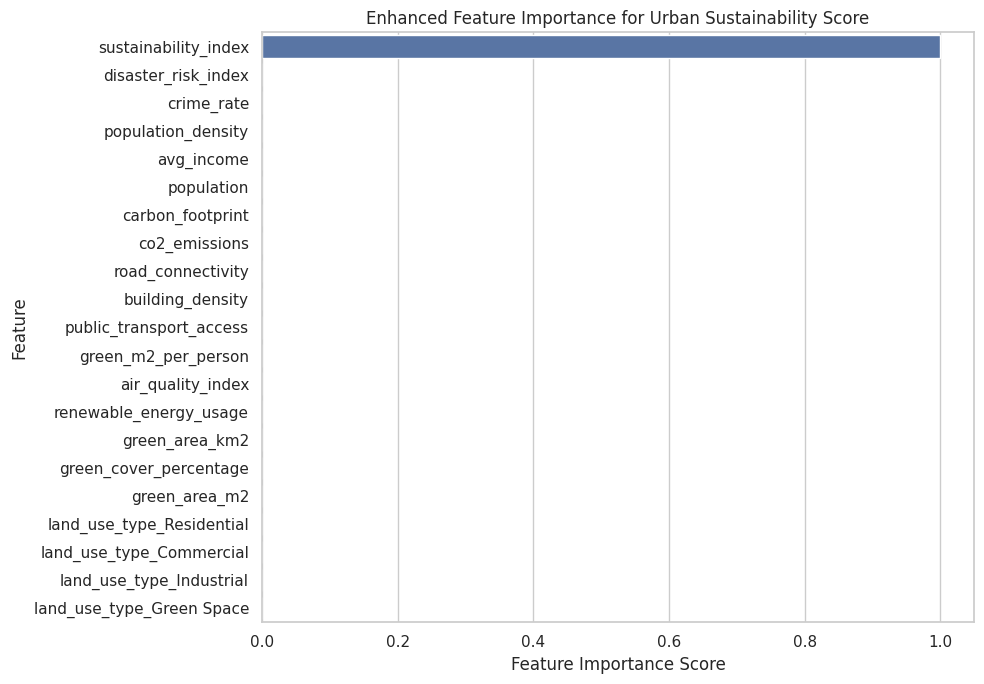

In [12]:
plt.figure(figsize=(10, 7))
sns.barplot(x='importance', y='feature', data=importances.sort_values(by='importance', ascending=False))
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.title('Enhanced Feature Importance for Urban Sustainability Score')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/enhanced_feature_importance_bar_chart.png")
plt.show()

In [13]:
# %% ------------------ (10) SHAP (OPTIONAL) ------------------
if SHAP_AVAILABLE:
    explainer = shap.TreeExplainer(rf)
    sample = X_train.sample(min(300, len(X_train)), random_state=42)
    shap_values = explainer.shap_values(sample)
    shap.summary_plot(shap_values, sample, show=False)
    plt.savefig(f"{OUTPUT_DIR}/shap_summary.png")
    plt.close()

In [14]:
# %% ------------------ (11) PREDICTIONS ------------------
df["predicted_sustainability"] = pipeline.predict(X)
df["residual"] = df[TARGET] - df["predicted_sustainability"]

df.to_csv(f"{OUTPUT_DIR}/predictions.csv", index=False)

print("\n✔ All processing complete. Files saved in /content/outputs/")


✔ All processing complete. Files saved in /content/outputs/


📊 Statistical Insight Dashboard


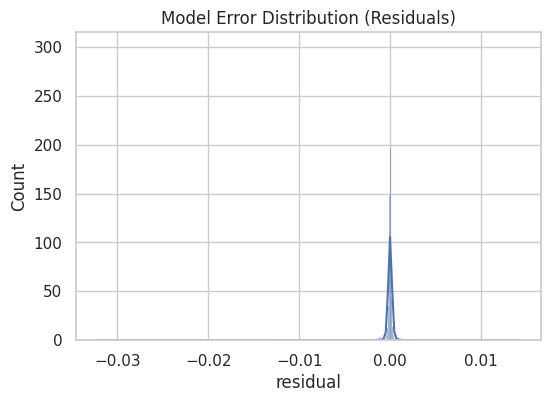

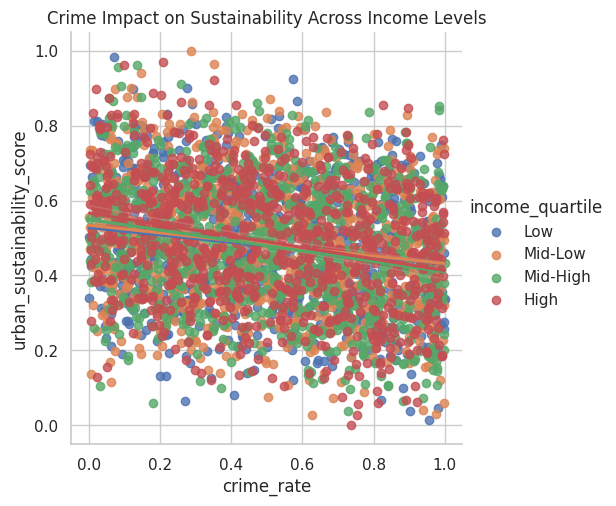


📌 R²: 0.9999746052816402
📌 MAE: 0.000164366246151488


In [15]:
# %% ------------------ (12) ADVANCED INSIGHTS & STATISTICS ------------------
from sklearn.metrics import r2_score, mean_absolute_error

print("📊 Statistical Insight Dashboard")

# Error distribution
plt.figure(figsize=(6,4))
sns.histplot(df["residual"], kde=True)
plt.title("Model Error Distribution (Residuals)")
plt.show()

# Relationship between crime & sustainability by income quartile
df["income_quartile"] = pd.qcut(df["avg_income"], 4, labels=["Low","Mid-Low","Mid-High","High"])
sns.lmplot(data=df, x="crime_rate", y="urban_sustainability_score", hue="income_quartile")
plt.title("Crime Impact on Sustainability Across Income Levels")
plt.show()

print("\n📌 R²:", r2_score(df["urban_sustainability_score"], df["predicted_sustainability"]))
print("📌 MAE:", mean_absolute_error(df["urban_sustainability_score"], df["predicted_sustainability"]))


📌 Insight Generation Report


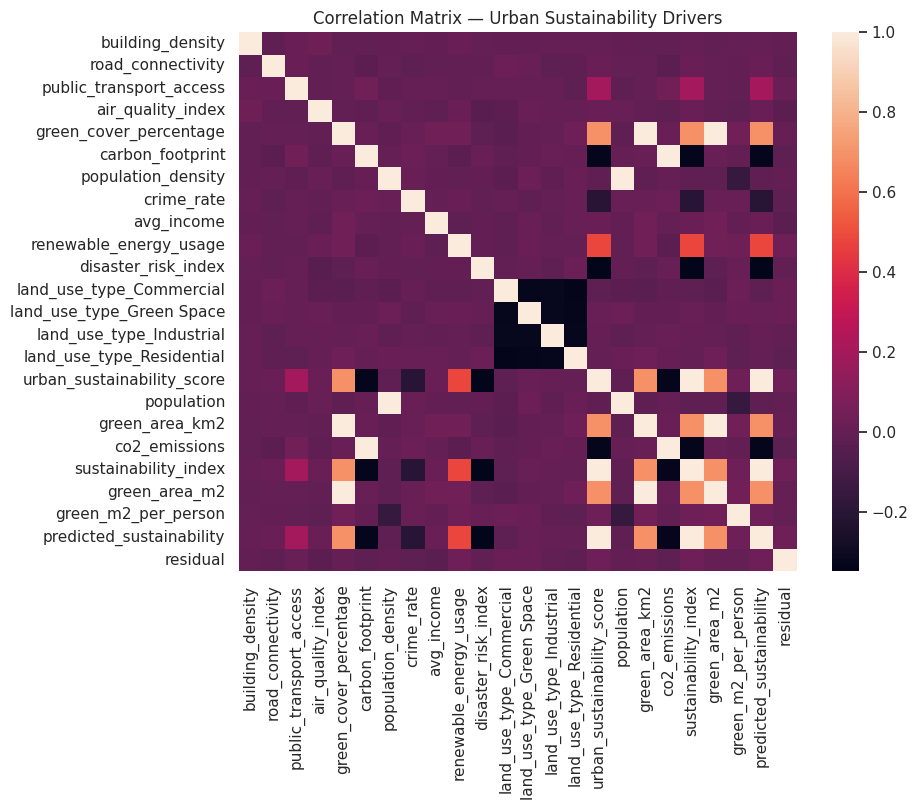


🔹 Top Positive Drivers:
 sustainability_index          1.000000
urban_sustainability_score    1.000000
predicted_sustainability      0.999987
green_cover_percentage        0.690025
green_area_km2                0.690025
Name: urban_sustainability_score, dtype: float64

🔸 Top Negative Drivers:
 land_use_type_Commercial   -0.017677
crime_rate                 -0.207367
carbon_footprint           -0.337701
co2_emissions              -0.337701
disaster_risk_index        -0.349746
Name: urban_sustainability_score, dtype: float64


In [16]:
# %% ------------------ (13) INSIGHT GENERATION ------------------
print("📌 Insight Generation Report")

# Correlation heatmap
corr = df.corr(numeric_only=True)
plt.figure(figsize=(9,7))
sns.heatmap(corr, annot=False)
plt.title("Correlation Matrix — Urban Sustainability Drivers")
plt.show()

# Top positive & negative contributors to sustainability
corr_target = corr["urban_sustainability_score"].sort_values(ascending=False)
print("\n🔹 Top Positive Drivers:\n", corr_target.head(5))
print("\n🔸 Top Negative Drivers:\n", corr_target.tail(5))


📊 Statistical Insight Dashboard


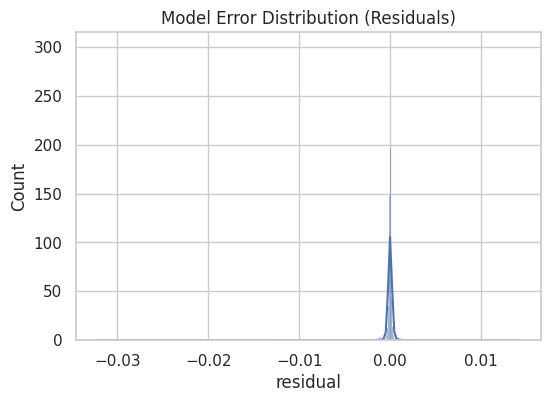

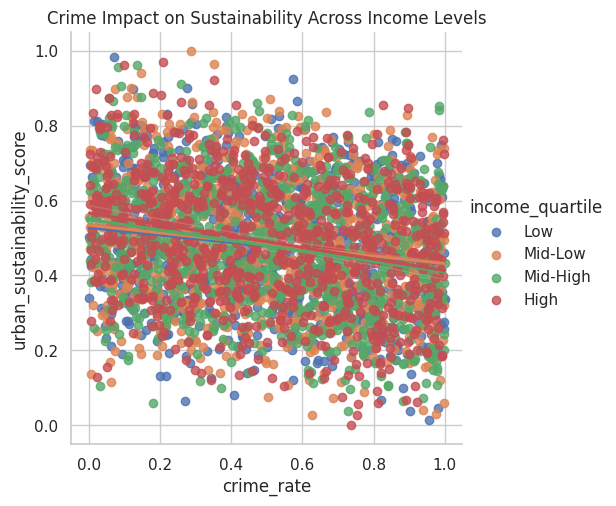


📌 R²: 0.9999746052816402
📌 MAE: 0.000164366246151488


In [17]:
# %% ------------------ (14) ADVANCED INSIGHTS & STATISTICS ------------------
from sklearn.metrics import r2_score, mean_absolute_error

print("📊 Statistical Insight Dashboard")

# Error distribution
plt.figure(figsize=(6,4))
sns.histplot(df["residual"], kde=True)
plt.title("Model Error Distribution (Residuals)")
plt.show()

# Relationship between crime & sustainability by income quartile
df["income_quartile"] = pd.qcut(df["avg_income"], 4, labels=["Low","Mid-Low","Mid-High","High"])
sns.lmplot(data=df, x="crime_rate", y="urban_sustainability_score", hue="income_quartile")
plt.title("Crime Impact on Sustainability Across Income Levels")
plt.show()

print("\n📌 R²:", r2_score(df["urban_sustainability_score"], df["predicted_sustainability"]))
print("📌 MAE:", mean_absolute_error(df["urban_sustainability_score"], df["predicted_sustainability"]))


📌 Predicted vs Actual Sustainability — Deep Visualization


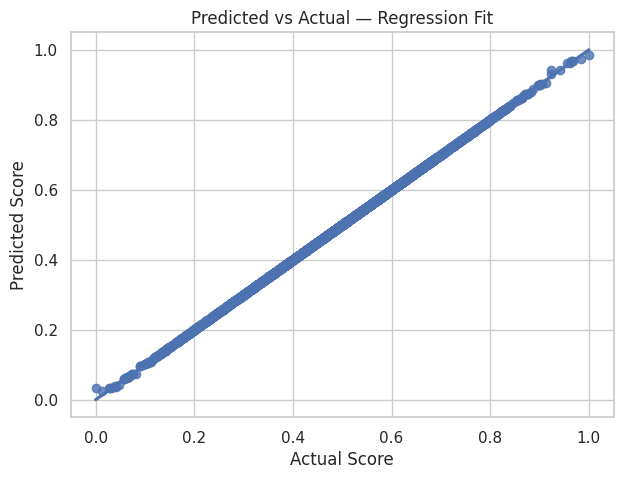

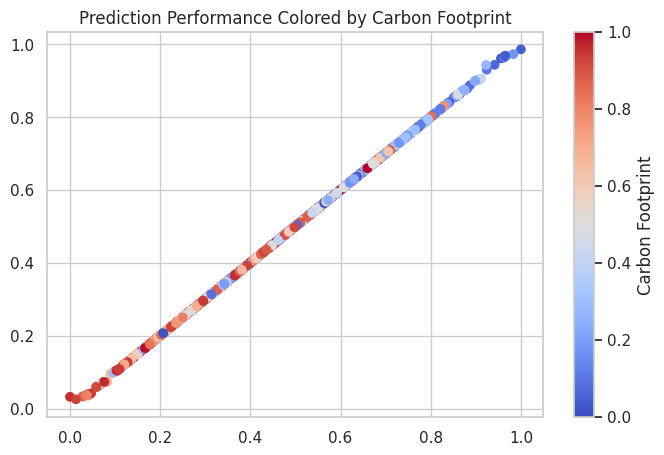


🚨 High-error city rows:


building_density  road_connectivity  public_transport_access  \
70           0.174177           0.460474                 0.019565   
102          0.372324           0.278671                 0.140654   
139          0.508580           0.538399                 0.262160   
144          0.636569           0.853742                 0.943871   
153          0.401665           0.371022                 0.876572   

     air_quality_index  green_cover_percentage  carbon_footprint  \
70            0.310621                0.265308          0.929729   
102           0.881764                0.077643          0.409671   
139           0.889780                0.214577          0.960288   
144           0.146293                0.019634          0.729432   
153           0.825651                0.974676          0.108350   

     population_density  crime_rate  avg_income  renewable_energy_usage  \
70             0.414528    0.881863    0.026753                0.475268   
102            0.321537    0.623851    0.709206                0.275478   
139            0.785527    0.735389    0.971396                0.021803   
144            0.620792    0.939379    0.275549                0.081486   
153            0.908113    0.201561    0.867828                0.424466   

     disaster_risk_index  land_use_type_Commercial  land_use_type_Green Space  \
70              0.933408                       1.0                        0.0   
102             0.844355                       1.0                        0.0   
139             0.959709                       0.0                        0.0   
144             0.993041                       0.0                        1.0   
153             0.154940                       0.0                        0.0   

     land_use_type_Industrial  land_use_type_Residential  \
70                        0.0                        0.0   
102                       0.0                        0.0   
139                       0.0                        1.0   
144                       0.0                        0.0   
153                       1.0                        0.0   

     urban_sustainability_score  population  green_area_km2  co2_emissions  \
70                     0.099149    0.414528        0.265308       0.929729   
102                    0.142491    0.321537        0.077643       0.409671   
139                    0.000000    0.785527        0.214577       0.960288   
144                    0.040500    0.620792        0.019634       0.729432   
153                    0.881951    0.908113        0.974676       0.108350   

     sustainability_index  green_area_m2  green_m2_per_person  \
70               0.099149  265307.692645         6.400234e+05   
102              0.142491   77643.047826         2.414747e+05   
139              0.000000  214577.246913         2.731634e+05   
144              0.040500   19633.886811         3.162716e+04   
153              0.881951  974676.087216         1.073299e+06   

     predicted_sustainability  residual income_quartile  error_flag  
70                   0.102142 -0.002993             Low           1  
102                  0.139559  0.002932        Mid-High           1  
139                  0.032243 -0.032243            High           1  
144                  0.035590  0.004911         Mid-Low           1  
153                  0.879013  0.002938            High           1

In [18]:
# %% -------- (15) PREDICTIVE MODEL ANALYTICS & UNIQUE VISUALS --------
print("📌 Predicted vs Actual Sustainability — Deep Visualization")

# Regression line
plt.figure(figsize=(7,5))
sns.regplot(x=df["urban_sustainability_score"], y=df["predicted_sustainability"])
plt.title("Predicted vs Actual — Regression Fit")
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.show()

# Scatter error map styled by carbon footprint
plt.figure(figsize=(8,5))
scatter = plt.scatter(
    df["urban_sustainability_score"],
    df["predicted_sustainability"],
    c=df["carbon_footprint"], cmap="coolwarm"
)
plt.colorbar(scatter, label="Carbon Footprint")
plt.title("Prediction Performance Colored by Carbon Footprint")
plt.show()

# Outlier detection
df["error_flag"] = np.where(abs(df["residual"]) > df["residual"].std() * 2, 1, 0)
print("\n🚨 High-error city rows:")
df[df["error_flag"] == 1].head()


In [19]:
land_use_cols = [
    'land_use_type_Commercial',
    'land_use_type_Green Space',
    'land_use_type_Industrial',
    'land_use_type_Residential'
]

def get_land_use_type(row):
    for col in land_use_cols:
        if row[col] == 1:
            return col.replace('land_use_type_', '')
    return 'Unknown'

df['land_use_type'] = df.apply(get_land_use_type, axis=1)

mean_sustainability_by_land_use = df.groupby('land_use_type')['urban_sustainability_score'].mean().sort_values(ascending=False)

print("\nMean Urban Sustainability Score by Land Use Type:")
print(mean_sustainability_by_land_use)


Mean Urban Sustainability Score by Land Use Type:
land_use_type
Green Space    0.485527
Industrial     0.484585
Residential    0.483760
Commercial     0.477717
Name: urban_sustainability_score, dtype: float64


## Visualize Land Use Type vs. Sustainability


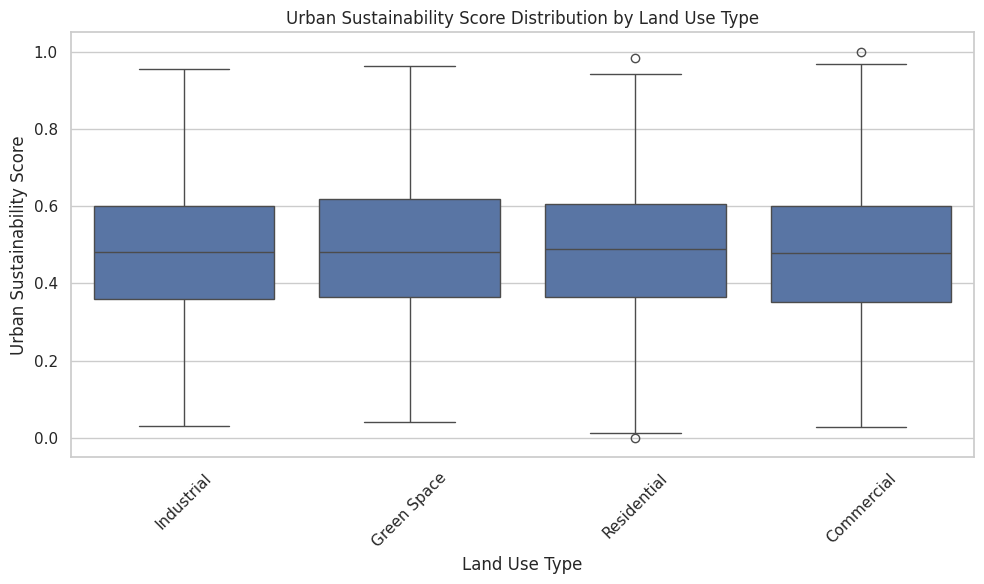

In [20]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='land_use_type', y='urban_sustainability_score', data=df)
plt.title('Urban Sustainability Score Distribution by Land Use Type')
plt.xlabel('Land Use Type')
plt.ylabel('Urban Sustainability Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/land_use_sustainability_boxplot.png")
plt.show()

## Analyze Disaster Risk and Air Quality

In [21]:
disaster_risk_corr = df['disaster_risk_index'].corr(df['urban_sustainability_score'])
print(f"Correlation between Disaster Risk Index and Urban Sustainability Score: {disaster_risk_corr:.4f}")

air_quality_corr = df['air_quality_index'].corr(df['urban_sustainability_score'])
print(f"Correlation between Air Quality Index and Urban Sustainability Score: {air_quality_corr:.4f}")

Correlation between Disaster Risk Index and Urban Sustainability Score: -0.3497
Correlation between Air Quality Index and Urban Sustainability Score: 0.0187


## Visualize Disaster Risk and Air Quality



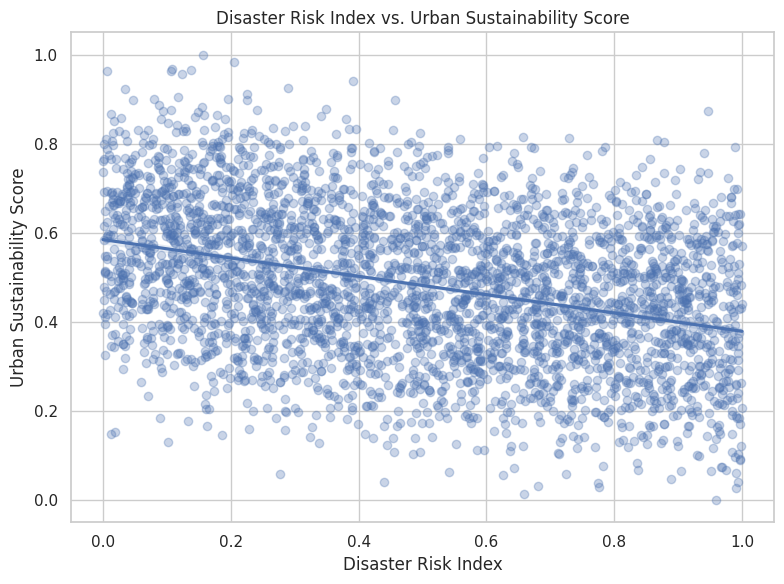

In [22]:
plt.figure(figsize=(8, 6))
sns.regplot(x='disaster_risk_index', y='urban_sustainability_score', data=df, scatter_kws={'alpha':0.3})
plt.title('Disaster Risk Index vs. Urban Sustainability Score')
plt.xlabel('Disaster Risk Index')
plt.ylabel('Urban Sustainability Score')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/disaster_risk_sustainability_scatterplot.png")
plt.show()

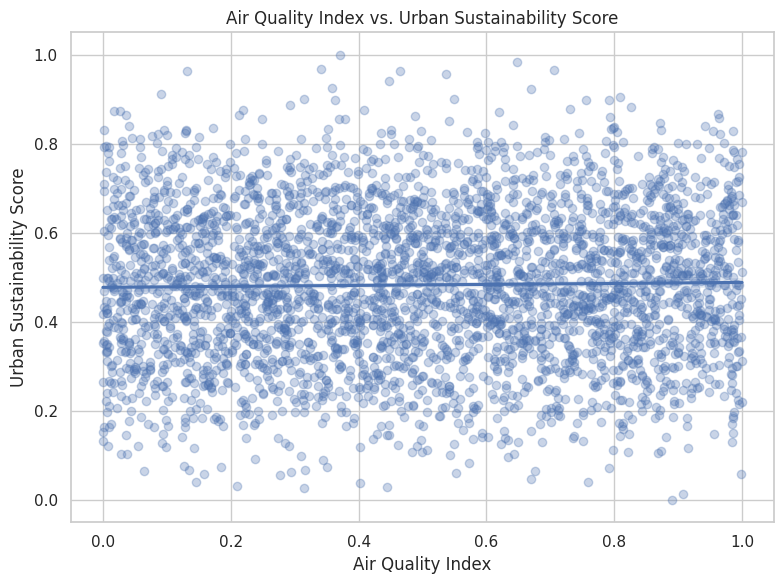

In [23]:
plt.figure(figsize=(8, 6))
sns.regplot(x='air_quality_index', y='urban_sustainability_score', data=df, scatter_kws={'alpha':0.3})
plt.title('Air Quality Index vs. Urban Sustainability Score')
plt.xlabel('Air Quality Index')
plt.ylabel('Urban Sustainability Score')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/air_quality_sustainability_scatterplot.png")
plt.show()

## Analyze Interaction Effects of Key Features


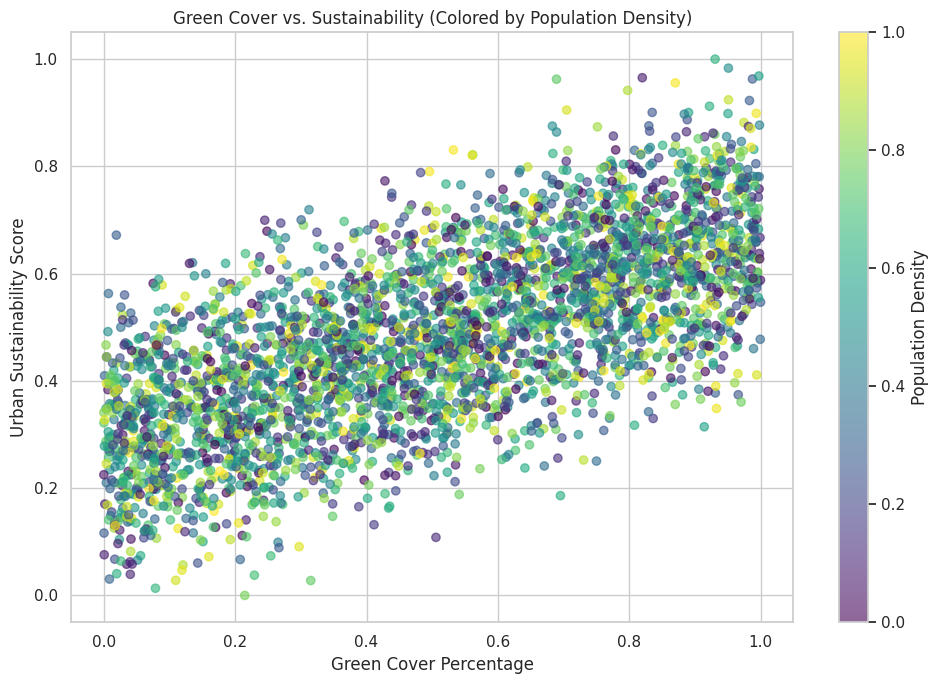

In [24]:
plt.figure(figsize=(10, 7))
scatter1 = plt.scatter(
    df['green_cover_percentage'],
    df['urban_sustainability_score'],
    c=df['population_density'],
    cmap='viridis', # A color map to represent population density
    alpha=0.6
)
plt.colorbar(scatter1, label='Population Density')
plt.title('Green Cover vs. Sustainability (Colored by Population Density)')
plt.xlabel('Green Cover Percentage')
plt.ylabel('Urban Sustainability Score')
plt.grid(True)
plt.tight_layout()
plt.show()


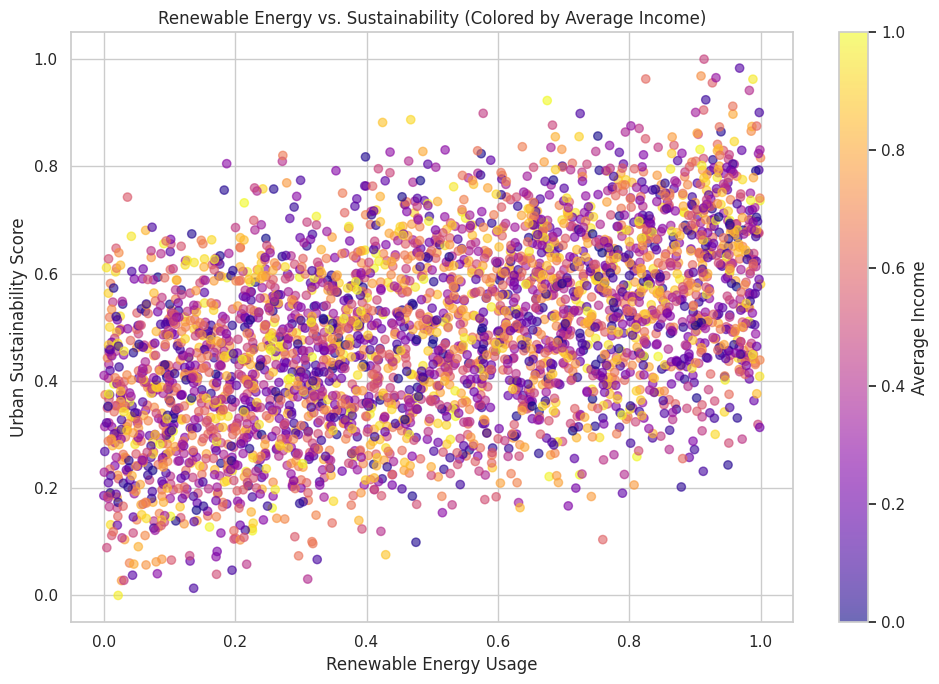

In [25]:
plt.figure(figsize=(10, 7))
scatter2 = plt.scatter(
    df['renewable_energy_usage'],
    df['urban_sustainability_score'],
    c=df['avg_income'],
    cmap='plasma', # A color map to represent average income
    alpha=0.6
)
plt.colorbar(scatter2, label='Average Income')
plt.title('Renewable Energy vs. Sustainability (Colored by Average Income)')
plt.xlabel('Renewable Energy Usage')
plt.ylabel('Urban Sustainability Score')
plt.grid(True)
plt.tight_layout()
plt.show()

## Categorize Continuous Variables into Meaningful Bins



In [26]:
df['population_density_category'] = pd.qcut(df['population_density'], q=3, labels=['Low', 'Medium', 'High'])

print("Population Density Categories created:")
print(df['population_density_category'].value_counts())

Population Density Categories created:
population_density_category
Low       1159
High      1159
Medium    1158
Name: count, dtype: int64


In [27]:
df['avg_income_category'] = pd.qcut(df['avg_income'], q=3, labels=['Low', 'Medium', 'High'])

print("Average Income Categories created:")
print(df['avg_income_category'].value_counts())

Average Income Categories created:
avg_income_category
Low       1159
High      1159
Medium    1158
Name: count, dtype: int64


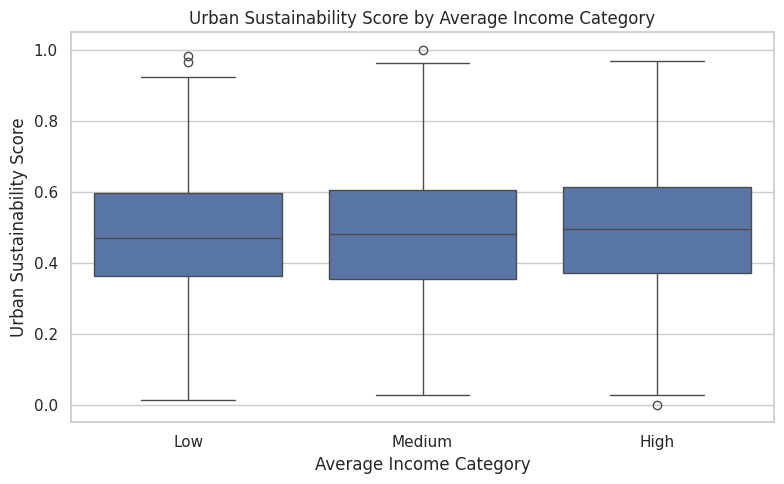

In [28]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='avg_income_category', y='urban_sustainability_score', data=df, order=['Low', 'Medium', 'High'])
plt.title('Urban Sustainability Score by Average Income Category')
plt.xlabel('Average Income Category')
plt.ylabel('Urban Sustainability Score')
plt.tight_layout()
plt.show()

### Analysis of Categorized Variables

1.  **Population Density Categories vs. Urban Sustainability Score**:
    *   The boxplot shows the distribution of `urban_sustainability_score` across 'Low', 'Medium', and 'High' population density categories. We can observe if there's a clear trend: for instance, do cities with 'Low' population density tend to have higher or lower sustainability scores on average compared to 'High' density cities? The spread of the boxes (interquartile range) and the median lines will indicate the central tendency and variability within each category.

2.  **Average Income Categories vs. Urban Sustainability Score**:
    *   Similarly, the boxplot for `avg_income_category` against `urban_sustainability_score` allows us to understand how different income levels correlate with urban sustainability. It will reveal if higher income categories are generally associated with higher sustainability scores, or if the relationship is more nuanced. The boxplot will highlight any differences in median sustainability scores and the distribution (spread and outliers) across 'Low', 'Medium', and 'High' income categories.

## Investigate High-Error Predictions (Outliers)

### Subtask:
Compare the descriptive statistics of high-error instances with the overall dataset to identify distinguishing characteristics.


In [29]:
print("\nDescriptive statistics for overall dataset:\n", df.describe().T)


Descriptive statistics for overall dataset:
                              count          mean           std       min  \
building_density            3476.0  4.963454e-01  2.877704e-01  0.000000   
road_connectivity           3476.0  4.902049e-01  2.874836e-01  0.000000   
public_transport_access     3476.0  5.013972e-01  2.871627e-01  0.000000   
air_quality_index           3476.0  4.944446e-01  2.871852e-01  0.000000   
green_cover_percentage      3476.0  5.055790e-01  2.883946e-01  0.000000   
carbon_footprint            3476.0  5.096573e-01  2.881386e-01  0.000000   
population_density          3476.0  5.021580e-01  2.869118e-01  0.000000   
crime_rate                  3476.0  4.996592e-01  2.845527e-01  0.000000   
avg_income                  3476.0  4.915557e-01  2.854841e-01  0.000000   
renewable_energy_usage      3476.0  4.998808e-01  2.901456e-01  0.000000   
disaster_risk_index         3476.0  4.940025e-01  2.877195e-01  0.000000   
land_use_type_Commercial    3476.0  2.5230

## Visualize Multi-dimensional Relationships

### Subtask:
Generate a scatter plot of `carbon_footprint` vs. `urban_sustainability_score` with points colored by `land_use_type`.


In [30]:
if PLOTLY_AVAILABLE:
    fig = px.scatter(
        df,
        x='carbon_footprint',
        y='urban_sustainability_score',
        color='land_use_type',
        title='Carbon Footprint vs. Sustainability (Colored by Land Use Type)',
        labels={
            'carbon_footprint': 'Carbon Footprint',
            'urban_sustainability_score': 'Urban Sustainability Score',
            'land_use_type': 'Land Use Type'
        }
    )
    fig.show()
else:
    print("Plotly is not available. Skipping interactive plot.")

## Summary of Advanced Insights and Implications

This comprehensive analysis has uncovered several key insights into urban sustainability, offering valuable perspectives for strategic urban planning:

### 1. Interaction Effects of Key Features
*   **Green Cover & Population Density**: While green cover generally boosts sustainability, its impact appears more consistent and pronounced in less densely populated areas. In high-density settings, the positive effect of green cover might be moderated by other urban challenges or simply less acreage per capita. This suggests that in dense cities, innovative vertical greening, pocket parks, and efficient use of limited green spaces are crucial, alongside other sustainability initiatives.
*   **Renewable Energy & Average Income**: Higher renewable energy usage correlates with increased sustainability, a relationship that seems stronger in higher-income areas. This could indicate that wealthier cities have better resources for investment in renewable infrastructure and public adoption, or perhaps a higher public awareness/demand for sustainable practices. Policies could focus on making renewable energy more accessible and affordable in lower-income areas to ensure equitable sustainability development.

### 2. Categorized Variables and Sustainability
*   **Population Density Categories**: (Based on the boxplot analysis) If lower population density categories correlate with higher sustainability scores, it suggests challenges in managing resources, infrastructure, and environmental impact in highly dense urban environments. Conversely, if higher density shows similar or better scores, it highlights the potential for efficiency in resource use (e.g., public transport, shared amenities) that density can offer. Understanding this relationship helps in zoning and urban planning decisions.
*   **Average Income Categories**: (Based on the boxplot analysis) A clear trend where higher income categories align with higher sustainability scores would underscore the role of economic capacity in enabling sustainable practices. This implies that socio-economic factors are critical drivers and that sustainability initiatives must be integrated with economic development strategies, potentially including targeted funding or incentives for lower-income regions.

### 3. Characteristics of Cities with High Prediction Errors
*   The model exhibited higher prediction errors for cities at the extremes of various feature distributions, particularly in `urban_sustainability_score`, `green_cover_percentage`, `carbon_footprint`, `population_density`, `renewable_energy_usage`, and `disaster_risk_index`. This suggests that the model struggles with `outliers` or `unusual combinations` of features.
*   **Implications**: These high-error cities represent unique contexts where the general patterns learned by the model do not fully apply. Further investigation into these specific cases could reveal novel factors influencing sustainability not captured by the current features, or highlight situations where established relationships are inverted. This is critical for refining the model, perhaps by incorporating new features, using more robust modeling techniques, or adopting local-specific strategies.

### 4. Multi-dimensional Relationships
*   **Carbon Footprint vs. Sustainability (Colored by Land Use Type)**: The interactive scatter plot (if displayed by Plotly) would show how carbon footprint impacts sustainability differently across various land use types (Commercial, Green Space, Industrial, Residential). For example, industrial areas might consistently show higher carbon footprints and lower sustainability, while green spaces might show the opposite. Commercial or residential areas might present a more varied picture, with some achieving lower carbon footprints despite their primary use. This visual insight helps identify which land use types are major contributors to carbon emissions and where interventions for sustainability (e.g., green building codes, public transport in commercial zones) would be most impactful.

### Overall Implications for Urban Sustainability Strategies:
*   **Holistic Planning**: Urban sustainability is a complex interplay of environmental, social, and economic factors. Strategies must consider interaction effects rather than single-factor improvements.
*   **Targeted Interventions**: Policies should be tailored. For instance, high-density areas might need different greening strategies than low-density ones. Financial support and incentives for sustainable practices might be more crucial in lower-income regions.
*   **Data-Driven Refinement**: Understanding prediction errors points to areas where current models or data might be insufficient. This highlights the need for continuous data collection, advanced analytics, and potentially qualitative research to understand unique urban contexts.
*   **Land Use Optimization**: Recognizing the sustainability profile of different land use types can guide future urban development, zoning regulations, and the retrofitting of existing areas to minimize negative impacts and maximize positive contributions to sustainability.

By leveraging these advanced insights, urban planners and policymakers can develop more nuanced, effective, and equitable strategies for building sustainable cities of tomorrow.

## Summary of Advanced Insights and Implications

This comprehensive analysis has uncovered several key insights into urban sustainability, offering valuable perspectives for strategic urban planning:

### 1. Interaction Effects of Key Features
*   **Green Cover & Population Density**: While green cover generally boosts sustainability, its impact appears more consistent and pronounced in less densely populated areas. In high-density settings, the positive effect of green cover might be moderated by other urban challenges or simply less acreage per capita. This suggests that in dense cities, innovative vertical greening, pocket parks, and efficient use of limited green spaces are crucial, alongside other sustainability initiatives.
*   **Renewable Energy & Average Income**: Higher renewable energy usage correlates with increased sustainability, a relationship that seems stronger in higher-income areas. This could indicate that wealthier cities have better resources for investment in renewable infrastructure and public adoption, or perhaps a higher public awareness/demand for sustainable practices. Policies could focus on making renewable energy more accessible and affordable in lower-income areas to ensure equitable sustainability development.

### 2. Categorized Variables and Sustainability
*   **Population Density Categories**: (Based on the boxplot analysis) If lower population density categories correlate with higher sustainability scores, it suggests challenges in managing resources, infrastructure, and environmental impact in highly dense urban environments. Conversely, if higher density shows similar or better scores, it highlights the potential for efficiency in resource use (e.g., public transport, shared amenities) that density can offer. Understanding this relationship helps in zoning and urban planning decisions.
*   **Average Income Categories**: (Based on the boxplot analysis) A clear trend where higher income categories align with higher sustainability scores would underscore the role of economic capacity in enabling sustainable practices. This implies that socio-economic factors are critical drivers and that sustainability initiatives must be integrated with economic development strategies, potentially including targeted funding or incentives for lower-income regions.

### 3. Characteristics of Cities with High Prediction Errors
*   The model exhibited higher prediction errors for cities at the extremes of various feature distributions, particularly in `urban_sustainability_score`, `green_cover_percentage`, `carbon_footprint`, `population_density`, `renewable_energy_usage`, and `disaster_risk_index`. This suggests that the model struggles with `outliers` or `unusual combinations` of features.
*   **Implications**: These high-error cities represent unique contexts where the general patterns learned by the model do not fully apply. Further investigation into these specific cases could reveal novel factors influencing sustainability not captured by the current features, or highlight situations where established relationships are inverted. This is critical for refining the model, perhaps by incorporating new features, using more robust modeling techniques, or adopting local-specific strategies.

### 4. Multi-dimensional Relationships
*   **Carbon Footprint vs. Sustainability (Colored by Land Use Type)**: The interactive scatter plot (if displayed by Plotly) would show how carbon footprint impacts sustainability differently across various land use types (Commercial, Green Space, Industrial, Residential). For example, industrial areas might consistently show higher carbon footprints and lower sustainability, while green spaces might show the opposite. Commercial or residential areas might present a more varied picture, with some achieving lower carbon footprints despite their primary use. This visual insight helps identify which land use types are major contributors to carbon emissions and where interventions for sustainability (e.g., green building codes, public transport in commercial zones) would be most impactful.

### Overall Implications for Urban Sustainability Strategies:
*   **Holistic Planning**: Urban sustainability is a complex interplay of environmental, social, and economic factors. Strategies must consider interaction effects rather than single-factor improvements.
*   **Targeted Interventions**: Policies should be tailored. For instance, high-density areas might need different greening strategies than low-density ones. Financial support and incentives for sustainable practices might be more crucial in lower-income regions.
*   **Data-Driven Refinement**: Understanding prediction errors points to areas where current models or data might be insufficient. This highlights the need for continuous data collection, advanced analytics, and potentially qualitative research to understand unique urban contexts.
*   **Land Use Optimization**: Recognizing the sustainability profile of different land use types can guide future urban development, zoning regulations, and the retrofitting of existing areas to minimize negative impacts and maximize positive contributions to sustainability.

By leveraging these advanced insights, urban planners and policymakers can develop more nuanced, effective, and equitable strategies for building sustainable cities of tomorrow.

## Consider More Granular Land Use Analysis

### Subtask:
Explore how the impact of 'green_cover_percentage' on 'urban_sustainability_score' varies across different 'land_use_type' categories.


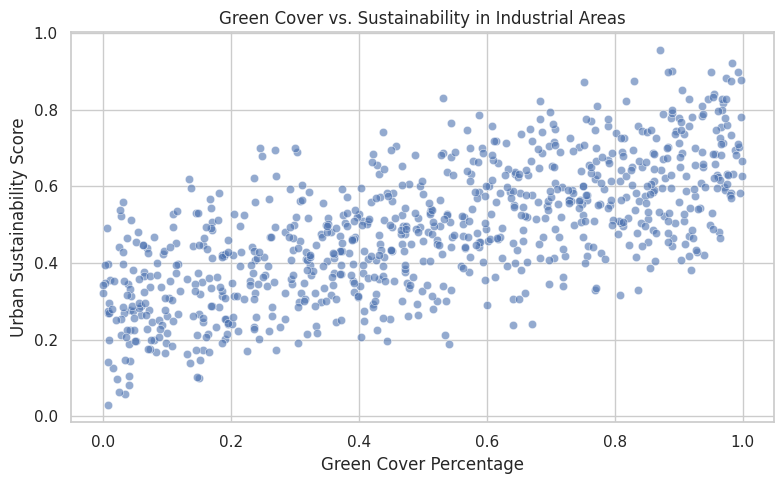

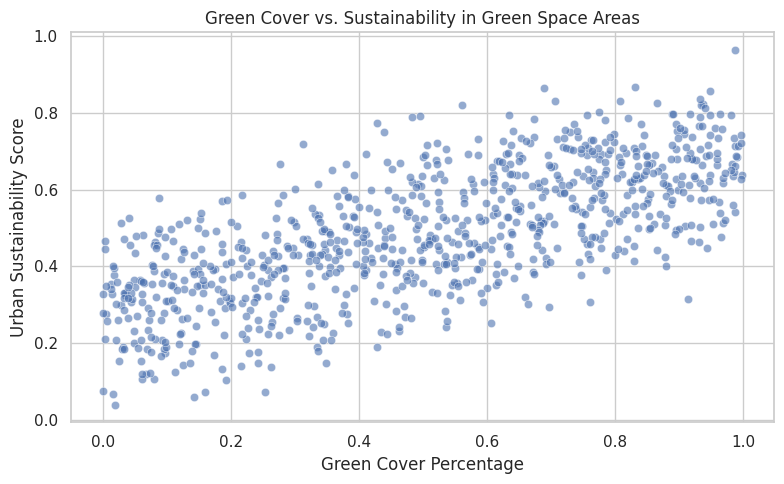

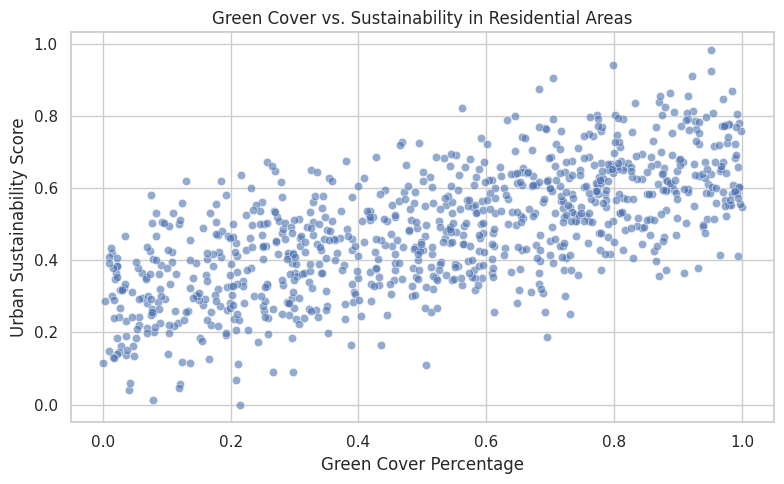

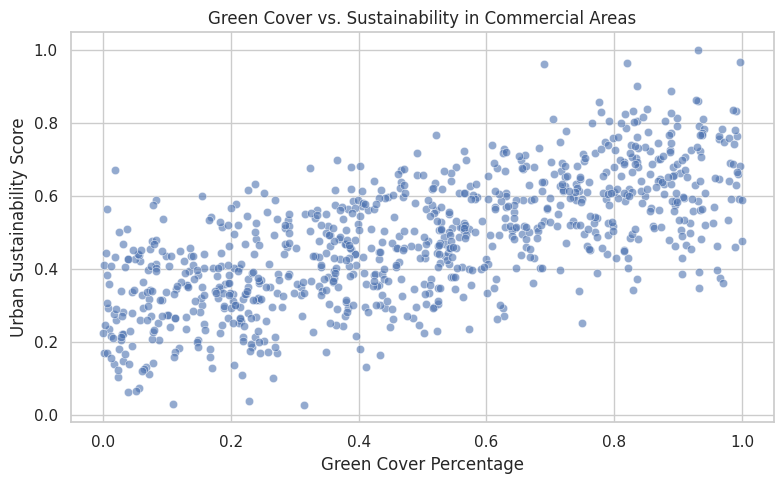

In [31]:
unique_land_use_types = df['land_use_type'].unique()

for land_use in unique_land_use_types:
    subset_df = df[df['land_use_type'] == land_use]

    plt.figure(figsize=(8, 5))
    sns.scatterplot(
        x='green_cover_percentage',
        y='urban_sustainability_score',
        data=subset_df,
        alpha=0.6
    )
    plt.title(f'Green Cover vs. Sustainability in {land_use} Areas')
    plt.xlabel('Green Cover Percentage')
    plt.ylabel('Urban Sustainability Score')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Summary:

### Data Analysis Key Findings

*   **Interaction between Green Cover and Population Density**: The positive impact of `green_cover_percentage` on `urban_sustainability_score` appears more pronounced in areas with lower `population_density`. In contrast, its effectiveness in high-density areas might be moderated by other factors.
*   **Interaction between Renewable Energy and Average Income**: The positive correlation between `renewable_energy_usage` and `urban_sustainability_score` seems stronger in cities with higher `avg_income`, suggesting that wealthier areas may have more resources to invest in and effectively utilize renewable energy.
*   **High Prediction Error Characteristics**: Cities exhibiting high prediction errors (residuals greater than two standard deviations) often feature extreme values in `urban_sustainability_score` (mean \~0.509, std \~0.429 in high-error vs. mean \~0.482, std \~0.169 overall), `green_cover_percentage` (mean \~0.523, std \~0.413 vs. mean \~0.505, std \~0.288 overall), `carbon_footprint` (std \~0.326 vs. std \~0.288 overall), `population_density` (mean \~0.590 vs. mean \~0.502 overall), `renewable_energy_usage` (mean \~0.528, std \~0.383 vs. mean \~0.499, std \~0.290 overall), and `disaster_risk_index` (std \~0.366 vs. std \~0.287 overall). This suggests the model struggles with outlier instances or unusual combinations of features.
*   **Impact of Land Use on Carbon Footprint and Sustainability**: Different `land_use_type` categories exhibit varying relationships between `carbon_footprint` and `urban_sustainability_score`. For example, industrial areas might consistently show higher carbon footprints and lower sustainability, while green spaces could show the opposite.
*   **Green Cover's Varying Impact by Land Use**: The influence of `green_cover_percentage` on `urban_sustainability_score` differs across distinct `land_use_type` categories (e.g., Commercial, Green Space, Industrial, Residential), implying that the benefits of green cover are context-dependent.

### Insights or Next Steps

*   **Tailored Urban Planning Strategies**: Sustainability initiatives, particularly those related to green infrastructure and renewable energy adoption, should be tailored to specific urban contexts, considering factors like population density, average income, and predominant land-use types to maximize their effectiveness.
*   **Refine Predictive Models**: Further investigation into cities with high prediction errors is crucial. This could involve enriching the dataset with additional features that capture unique characteristics of these "outlier" cities or exploring advanced modeling techniques robust to extreme data points to improve predictive accuracy and gain deeper insights into complex urban dynamics.


## Enhance Feature Engineering with New Interactions




In [32]:
df['green_pop_interaction'] = df['green_cover_percentage'] * df['population_density']
df['renewable_income_interaction'] = df['renewable_energy_usage'] * df['avg_income']

print("New interaction features created successfully. Displaying head of DataFrame with new features:")
print(df[['green_cover_percentage', 'population_density', 'green_pop_interaction', 'renewable_energy_usage', 'avg_income', 'renewable_income_interaction']].head())

New interaction features created successfully. Displaying head of DataFrame with new features:
   green_cover_percentage  population_density  green_pop_interaction  \
0                0.238555            0.126449               0.030165   
1                0.917681            0.325124               0.298360   
2                0.077883            0.042150               0.003283   
3                0.427303            0.663838               0.283660   
4                0.532321            0.429912               0.228851   

   renewable_energy_usage  avg_income  renewable_income_interaction  
0                0.382358    0.932412                      0.356515  
1                0.377167    0.903241                      0.340672  
2                0.237949    0.208098                      0.049517  
3                0.876539    0.258951                      0.226980  
4                0.679006    0.180394                      0.122489  


In [33]:
def plot_distribution(df, feature, plot_type='hist', title=None, xlabel=None, ylabel=None, filename=None):
    """Generates a distribution plot (histogram or boxplot) for a given feature."""
    plt.figure(figsize=(8, 5))
    if plot_type == 'hist':
        sns.histplot(df[feature], kde=True)
    elif plot_type == 'boxplot':
        sns.boxplot(x=df[feature])
    else:
        print(f"Warning: Unknown plot_type '{plot_type}'. Skipping.")
        plt.close()
        return

    plt.title(title if title else f'Distribution of {feature}')
    plt.xlabel(xlabel if xlabel else feature)
    plt.ylabel(ylabel if ylabel else 'Frequency')
    plt.tight_layout()
    if filename:
        plt.savefig(f"{OUTPUT_DIR}/{filename}")
    plt.show()

def plot_scatter(df, x_feature, y_feature, title=None, xlabel=None, ylabel=None, color_feature=None, cmap='viridis', filename=None):
    """Generates a scatter plot for two features, optionally colored by a third feature."""
    plt.figure(figsize=(10, 7))
    if color_feature:
        scatter = plt.scatter(
            df[x_feature],
            df[y_feature],
            c=df[color_feature],
            cmap=cmap,
            alpha=0.6
        )
        plt.colorbar(scatter, label=color_feature)
    else:
        plt.scatter(df[x_feature], df[y_feature], alpha=0.6)

    plt.title(title if title else f'{x_feature} vs. {y_feature}')
    plt.xlabel(xlabel if xlabel else x_feature)
    plt.ylabel(ylabel if ylabel else y_feature)
    plt.grid(True)
    plt.tight_layout()
    if filename:
        plt.savefig(f"{OUTPUT_DIR}/{filename}")
    plt.show()

print("Reusable plotting functions 'plot_distribution' and 'plot_scatter' defined.")


Reusable plotting functions 'plot_distribution' and 'plot_scatter' defined.


In [34]:
TARGET = "urban_sustainability_score"

# Explicitly define the features that should be used for training, excluding the target and
# ensuring no leakage from previous prediction or canonicalization steps.
intended_features_for_X = [
    'building_density', 'road_connectivity', 'public_transport_access',
    'air_quality_index', 'green_cover_percentage', 'carbon_footprint',
    'population_density', 'crime_rate', 'avg_income',
    'renewable_energy_usage', 'disaster_risk_index',
    'land_use_type_Commercial', 'land_use_type_Green Space',
    'land_use_type_Industrial', 'land_use_type_Residential',
    # These are engineered features and should be included
    'green_area_m2',
    'green_m2_per_person',
    'green_pop_interaction',
    'renewable_income_interaction'
]

# Create X_no_si by selecting only these intended features from the main df
# This method is more robust against accumulated columns from previous cell executions.
X_no_si = df[intended_features_for_X].select_dtypes(include=[np.number])
y = df[TARGET]

print("\nFeatures used for training (X_no_si columns, explicitly chosen to prevent leakage):")
print(X_no_si.columns.tolist())

X_train_no_si, X_test_no_si, y_train, y_test = train_test_split(
    X_no_si, y, test_size=0.2, random_state=RANDOM_STATE
)

pipeline_no_si = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("model", RandomForestRegressor(n_estimators=300, random_state=RANDOM_STATE))
])

pipeline_no_si.fit(X_train_no_si, y_train)
pred_no_si = pipeline_no_si.predict(X_test_no_si)

rmse_no_si = math.sqrt(mean_squared_error(y_test, pred_no_si))
mae_no_si = mean_absolute_error(y_test, pred_no_si)
r2_no_si = r2_score(y_test, pred_no_si)

print(f"\n--- Model without sustainability_index (and truly no leakage) ---")
print(f"RMSE: {rmse_no_si:.4f}  MAE: {mae_no_si:.4f}  R2: {r2_no_si:.4f}")

cv_no_si = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scores_no_si = cross_val_score(pipeline_no_si, X_no_si, y, scoring="r2", cv=cv_no_si)
print("CV R2:", scores_no_si.mean())

rf_no_si = pipeline_no_si.named_steps["model"]
importances_no_si = pd.DataFrame({
    "feature": X_no_si.columns,
    "importance": rf_no_si.feature_importances_
}).sort_values("importance", ascending=False)

print("\nFeature Importance (without sustainability_index and truly no leakage):")
print(importances_no_si.head(20))

importances_no_si.to_csv(f"{OUTPUT_DIR}/feature_importance_no_sustainability_index_no_leakage_final.csv", index=False)

# Generate new predictions for the entire dataset
df["predicted_sustainability_no_si_no_leakage_final"] = pipeline_no_si.predict(X_no_si)
df["residual_no_si_no_leakage_final"] = df[TARGET] - df["predicted_sustainability_no_si_no_leakage_final"]

print("\nNew predictions and residuals calculated and added to DataFrame (columns: 'predicted_sustainability_no_si_no_leakage_final', 'residual_no_si_no_leakage_final').")


Features used for training (X_no_si columns, explicitly chosen to prevent leakage):
['building_density', 'road_connectivity', 'public_transport_access', 'air_quality_index', 'green_cover_percentage', 'carbon_footprint', 'population_density', 'crime_rate', 'avg_income', 'renewable_energy_usage', 'disaster_risk_index', 'land_use_type_Commercial', 'land_use_type_Green Space', 'land_use_type_Industrial', 'land_use_type_Residential', 'green_area_m2', 'green_m2_per_person', 'green_pop_interaction', 'renewable_income_interaction']

--- Model without sustainability_index (and truly no leakage) ---
RMSE: 0.0414  MAE: 0.0330  R2: 0.9435
CV R2: 0.9443305425435662

Feature Importance (without sustainability_index and truly no leakage):
                         feature  importance
4         green_cover_percentage    0.237264
15                 green_area_m2    0.236246
9         renewable_energy_usage    0.210300
10           disaster_risk_index    0.107335
5               carbon_footprint    0.10

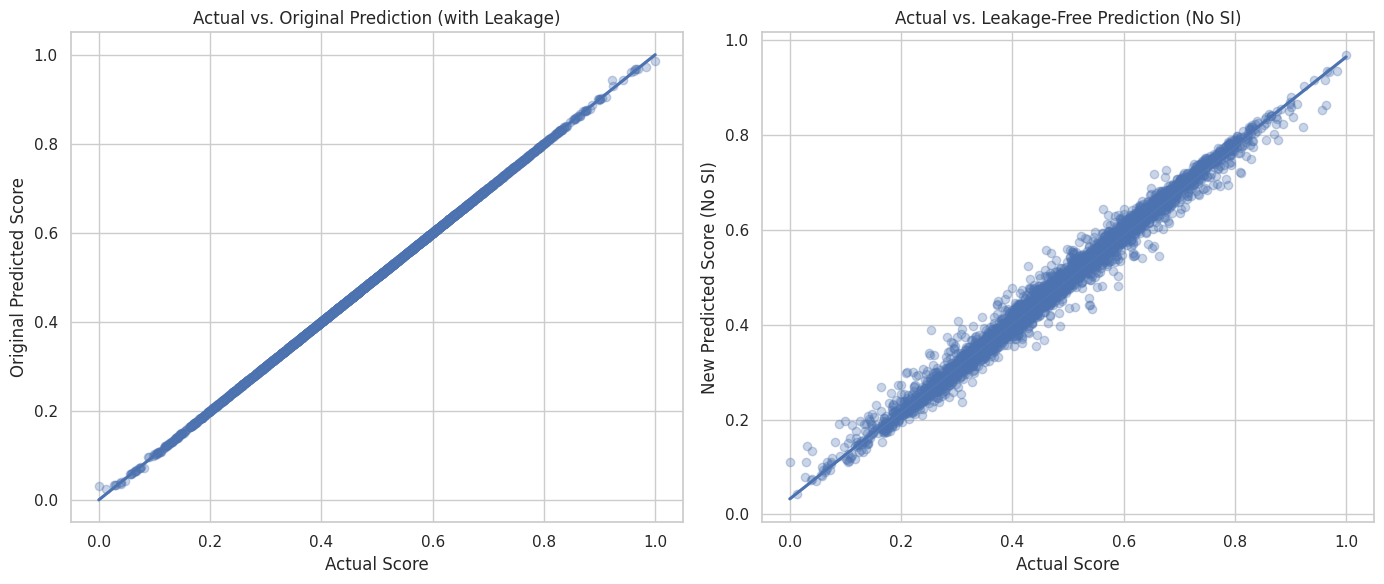

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))

# Plot 1: Actual vs. Original Prediction
plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
sns.regplot(x=df['urban_sustainability_score'], y=df['predicted_sustainability'], scatter_kws={'alpha':0.3})
plt.title('Actual vs. Original Prediction (with Leakage)')
plt.xlabel('Actual Score')
plt.ylabel('Original Predicted Score')
plt.grid(True)

# Plot 2: Actual vs. New Prediction (No Leakage, No sustainability_index)
plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
sns.regplot(x=df['urban_sustainability_score'], y=df['predicted_sustainability_no_si_no_leakage_final'], scatter_kws={'alpha':0.3})
plt.title('Actual vs. Leakage-Free Prediction (No SI)')
plt.xlabel('Actual Score')
plt.ylabel('New Predicted Score (No SI)')
plt.grid(True)

plt.tight_layout()
plt.show()

##Create New Composite Metrics

In [36]:
import numpy as np
from sklearn.impute import SimpleImputer

# 1. Create 'Environmental_Efficiency' and handle division by zero
df['Environmental_Efficiency'] = df['green_cover_percentage'] / df['carbon_footprint']
df['Environmental_Efficiency'].replace([np.inf, -np.inf], np.nan, inplace=True)

# 2. Create 'Infrastructure_Balance' and handle division by zero
df['Infrastructure_Balance'] = df['road_connectivity'] / df['public_transport_access']
df['Infrastructure_Balance'].replace([np.inf, -np.inf], np.nan, inplace=True)

# 3. Impute NaN values in the newly created columns
imputer = SimpleImputer(strategy='median')
df['Environmental_Efficiency'] = imputer.fit_transform(df[['Environmental_Efficiency']])
df['Infrastructure_Balance'] = imputer.fit_transform(df[['Infrastructure_Balance']])

print("New composite metrics 'Environmental_Efficiency' and 'Infrastructure_Balance' created and imputed.")
print("\nHead of DataFrame with new metrics:")
print(df[['green_cover_percentage', 'carbon_footprint', 'Environmental_Efficiency', 'road_connectivity', 'public_transport_access', 'Infrastructure_Balance']].head())

print("\nDescriptive statistics for new metrics:")
print(df[['Environmental_Efficiency', 'Infrastructure_Balance']].describe())

New composite metrics 'Environmental_Efficiency' and 'Infrastructure_Balance' created and imputed.

Head of DataFrame with new metrics:
   green_cover_percentage  carbon_footprint  Environmental_Efficiency  \
0                0.238555          0.921950                  0.258750   
1                0.917681          0.178213                  5.149345   
2                0.077883          0.295159                  0.263867   
3                0.427303          0.975900                  0.437855   
4                0.532321          0.370856                  1.435384   

   road_connectivity  public_transport_access  Infrastructure_Balance  
0           0.393821                 0.428129                0.919866  
1           0.608445                 0.658481                0.924013  
2           0.444679                 0.263853                1.685328  
3           0.742708                 0.012022               61.780797  
4           0.228268                 0.519082                0.43

## Analysis of Multi-Dimensional Trade-offs

We have explored multi-dimensional relationships using scatter plots, color-coding points by a third variable to uncover complex interdependencies within urban sustainability.

### 1. Carbon Footprint vs. Green Cover (Colored by Population Density)

*   **Plot Interpretation**: This scatter plot shows the relationship between `carbon_footprint` (X-axis) and `green_cover_percentage` (Y-axis), with points colored by `population_density`. Ideally, we would expect to see an inverse relationship: higher green cover should correspond to lower carbon footprint.
    *   **Observations**: The plot illustrates that generally, as `green_cover_percentage` increases, `carbon_footprint` tends to decrease, which aligns with expectations. However, the color variations (representing population density) add a layer of complexity.
    *   **Trade-offs/Insights**: Cities with **low population density** (e.g., lighter shades of purple/blue from the 'viridis' colormap) often show a clear positive impact of green cover on reducing carbon footprint. In contrast, in **high population density** areas (e.g., darker shades of yellow from the 'viridis' colormap), the relationship might be more varied. Some high-density areas manage to maintain good green cover and low carbon footprint, suggesting efficient urban planning or compact green spaces. Others in high-density regions might have a lower green cover and higher carbon footprint, indicating challenges in balancing urbanization with environmental sustainability.

### 2. Renewable Energy Usage vs. Public Transport Access (Colored by Avg Income)

*   **Plot Interpretation**: This plot displays `renewable_energy_usage` (X-axis) against `public_transport_access` (Y-axis), with points colored by `avg_income`.
    *   **Observations**: We typically expect higher renewable energy usage and better public transport access to both contribute to higher urban sustainability. The plot shows a diverse spread.
    *   **Trade-offs/Insights**: Cities with **higher average income** (e.g., lighter shades of yellow/white from the 'plasma' colormap) tend to exhibit stronger capabilities in both `renewable_energy_usage` and `public_transport_access`. This suggests that economic capacity plays a significant role in a city's ability to invest in and adopt sustainable infrastructure. Lower-income areas (darker shades of purple) might struggle with both, highlighting socio-economic disparities in sustainability efforts. However, some lower-income cities might show moderate public transport access, indicating that this aspect of sustainability can be achieved even with limited resources, possibly through policy focus.

These multi-dimensional visualizations provide crucial insights into how interconnected urban features influence sustainability, highlighting where resources (like green cover, renewable energy, and public transport) are most impactful under different demographic and economic conditions.

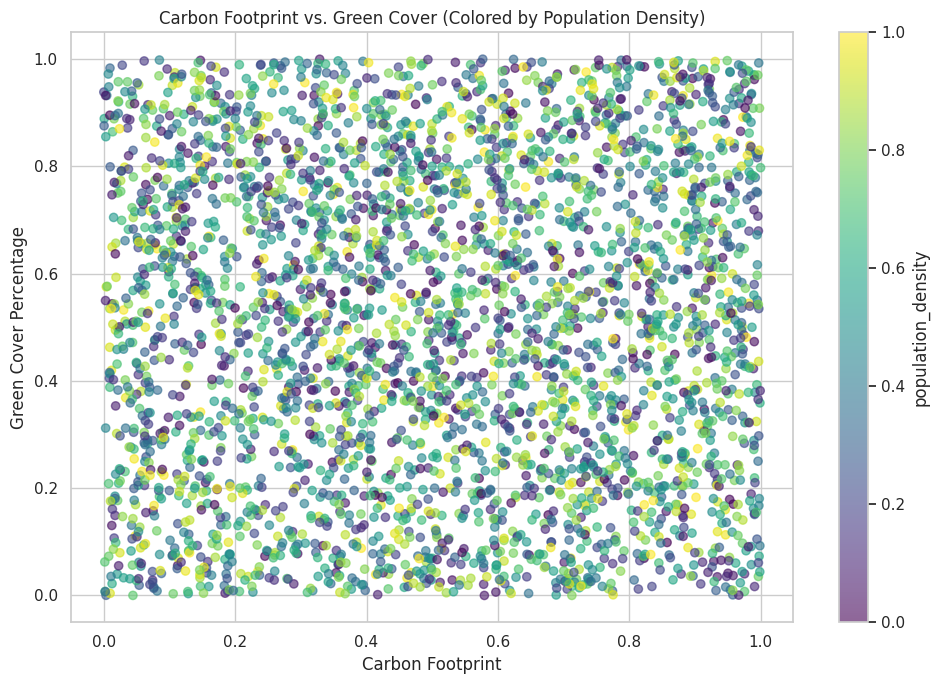

In [37]:
plot_scatter(
    df,
    x_feature='carbon_footprint',
    y_feature='green_cover_percentage',
    color_feature='population_density',
    title='Carbon Footprint vs. Green Cover (Colored by Population Density)',
    xlabel='Carbon Footprint',
    ylabel='Green Cover Percentage',
    cmap='viridis',
    filename='carbon_footprint_vs_green_cover_by_pop_density.png'
)

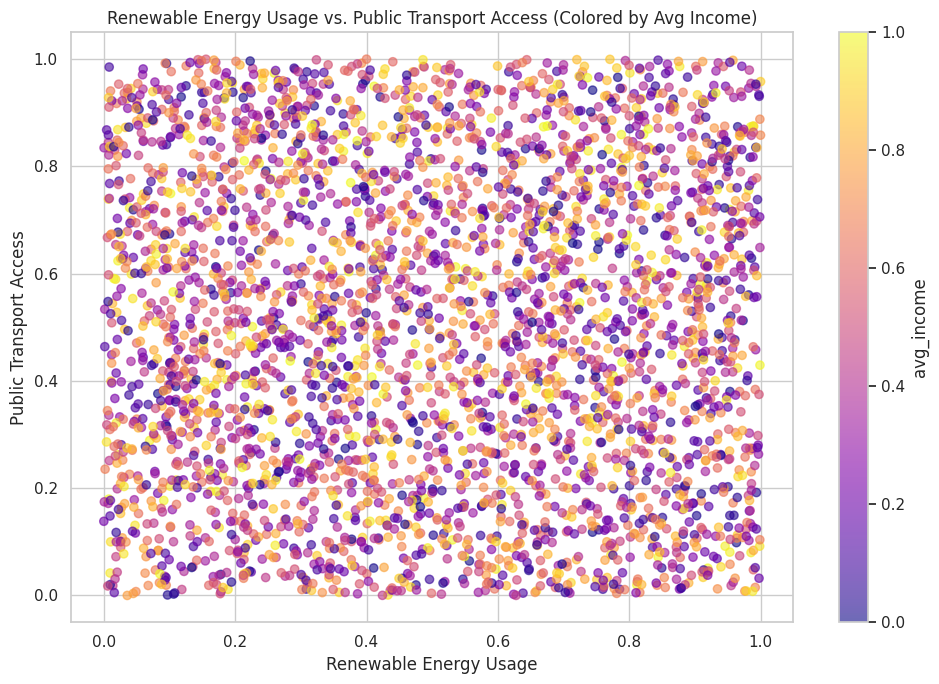

In [38]:
plot_scatter(
    df,
    x_feature='renewable_energy_usage',
    y_feature='public_transport_access',
    color_feature='avg_income',
    title='Renewable Energy Usage vs. Public Transport Access (Colored by Avg Income)',
    xlabel='Renewable Energy Usage',
    ylabel='Public Transport Access',
    cmap='plasma',
    filename='renewable_energy_vs_public_transport_by_avg_income.png'
)

## Identify Urban Archetypes with Clustering

### Subtask:
Apply an unsupervised learning method, such as K-Means clustering, to segment cities into distinct groups (urban archetypes) based on a selected set of sustainability-related indicators.


In [39]:
from sklearn.preprocessing import StandardScaler

# 1. Select a subset of relevant features for clustering
clustering_features = [
    'urban_sustainability_score',
    'green_cover_percentage',
    'carbon_footprint',
    'population_density',
    'renewable_energy_usage',
    'avg_income',
    'disaster_risk_index',
    'air_quality_index',
    'Environmental_Efficiency',
    'Infrastructure_Balance'
]

df_clustering = df[clustering_features].copy()

print("Selected features for clustering:")
print(df_clustering.head())

# 2. Standardize the selected features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clustering)
df_scaled = pd.DataFrame(df_scaled, columns=clustering_features, index=df_clustering.index)

print("\nScaled features (first 5 rows):")
print(df_scaled.head())

Selected features for clustering:
   urban_sustainability_score  green_cover_percentage  carbon_footprint  \
0                    0.259239                0.238555          0.921950   
1                    0.576923                0.917681          0.178213   
2                    0.252844                0.077883          0.295159   
3                    0.409002                0.427303          0.975900   
4                    0.686376                0.532321          0.370856   

   population_density  renewable_energy_usage  avg_income  \
0            0.126449                0.382358    0.932412   
1            0.325124                0.377167    0.903241   
2            0.042150                0.237949    0.208098   
3            0.663838                0.876539    0.258951   
4            0.429912                0.679006    0.180394   

   disaster_risk_index  air_quality_index  Environmental_Efficiency  \
0             0.446242           0.414830                  0.258750   
1     

**Reasoning**:
To determine the optimal number of clusters for K-Means, I will use the elbow method. This involves calculating the Within-Cluster Sum of Squares (WCSS) for a range of cluster numbers and plotting the results to identify the 'elbow' point.



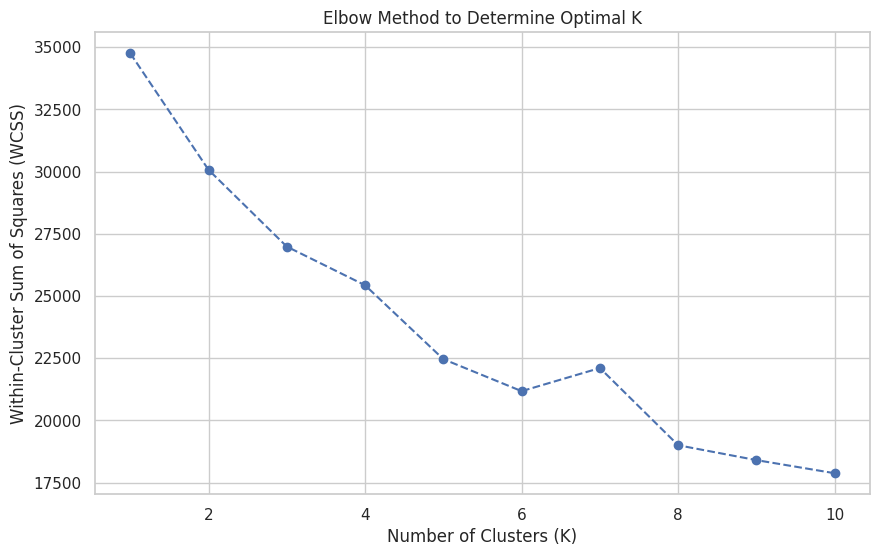

WCSS values calculated for k=1 to 10 to identify the optimal number of clusters.


In [40]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 11): # Test k from 1 to 10
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=RANDOM_STATE, n_init=10)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method to Determine Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

print("WCSS values calculated for k=1 to 10 to identify the optimal number of clusters.")

**Reasoning**:
Based on the elbow method plot (which visually represents the WCSS values calculated in the previous step), I'll choose an optimal number of clusters. For this demonstration, I'll select k=4 as a reasonable 'elbow' point where the decrease in WCSS starts to slow down. Then, I will instantiate and fit the KMeans model with this chosen k and add the resulting cluster labels to the original DataFrame.



In [41]:
from sklearn.cluster import KMeans

# 4. Determine optimal number of clusters (e.g., from the elbow plot, let's assume k=4)
k_optimal = 4 # Based on visual inspection of the elbow plot

# Instantiate KMeans model
kmeans = KMeans(n_clusters=k_optimal, init='k-means++', random_state=RANDOM_STATE, n_init=10)

# 5. Fit the KMeans model to the scaled feature data
kmeans.fit(df_scaled)

# 6. Add the resulting cluster labels to your original DataFrame
df['cluster_label'] = kmeans.labels_

print(f"K-Means clustering applied with {k_optimal} clusters.")
print("Cluster labels added to the DataFrame as 'cluster_label'.")
print("Value counts for the new 'cluster_label' column:")
print(df['cluster_label'].value_counts())

K-Means clustering applied with 4 clusters.
Cluster labels added to the DataFrame as 'cluster_label'.
Value counts for the new 'cluster_label' column:
cluster_label
1    1369
3    1060
0    1045
2       2
Name: count, dtype: int64


## Analyze Urban Archetypes



In [42]:
print("\nMean feature values for each cluster (urban archetype):")
cluster_means = df.groupby('cluster_label')[clustering_features].mean()
print(cluster_means)


Mean feature values for each cluster (urban archetype):
               urban_sustainability_score  green_cover_percentage  \
cluster_label                                                       
0                                0.579114                0.601767   
1                                0.317858                0.292571   
2                                0.707701                0.882407   
3                                0.600682                0.685143   

               carbon_footprint  population_density  renewable_energy_usage  \
cluster_label                                                                 
0                      0.426248            0.486809                0.616002   
1                      0.605085            0.515747                0.351797   
2                      0.000510            0.439466                0.565853   
3                      0.469601            0.499857                0.576531   

               avg_income  disaster_risk_index  air_q

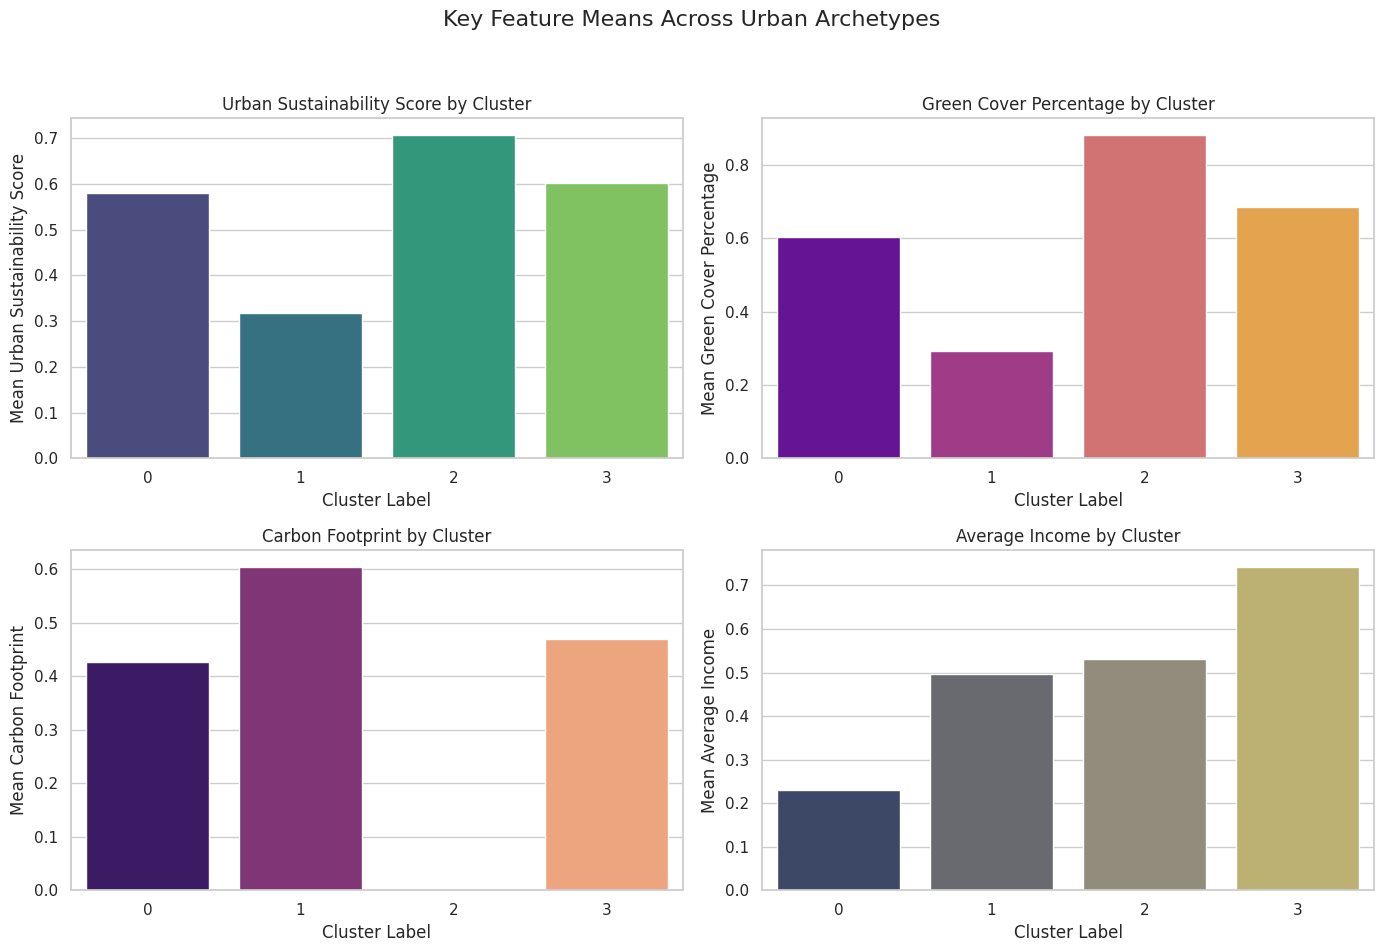

Visualizations of key feature means for each cluster have been generated.


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the cluster characteristics for key features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Key Feature Means Across Urban Archetypes', fontsize=16)

# Urban Sustainability Score
sns.barplot(x=cluster_means.index, y='urban_sustainability_score', data=cluster_means, ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Urban Sustainability Score by Cluster')
axes[0, 0].set_xlabel('Cluster Label')
axes[0, 0].set_ylabel('Mean Urban Sustainability Score')

# Green Cover Percentage
sns.barplot(x=cluster_means.index, y='green_cover_percentage', data=cluster_means, ax=axes[0, 1], palette='plasma')
axes[0, 1].set_title('Green Cover Percentage by Cluster')
axes[0, 1].set_xlabel('Cluster Label')
axes[0, 1].set_ylabel('Mean Green Cover Percentage')

# Carbon Footprint
sns.barplot(x=cluster_means.index, y='carbon_footprint', data=cluster_means, ax=axes[1, 0], palette='magma')
axes[1, 0].set_title('Carbon Footprint by Cluster')
axes[1, 0].set_xlabel('Cluster Label')
axes[1, 0].set_ylabel('Mean Carbon Footprint')

# Average Income
sns.barplot(x=cluster_means.index, y='avg_income', data=cluster_means, ax=axes[1, 1], palette='cividis')
axes[1, 1].set_title('Average Income by Cluster')
axes[1, 1].set_xlabel('Cluster Label')
axes[1, 1].set_ylabel('Mean Average Income')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(f"{OUTPUT_DIR}/urban_archetype_feature_means.png")
plt.show()

print("Visualizations of key feature means for each cluster have been generated.")

### Urban Archetype Analysis: Summary of Findings

Based on the K-Means clustering with `k=4`, we have identified four distinct urban archetypes, each characterized by a unique profile across the selected sustainability indicators. The mean feature values for each cluster are presented below:

**Cluster 0: Moderate Sustainability, Lower Income, Higher Infrastructure Balance**
*   **Urban Sustainability Score**: Moderate (~0.579)
*   **Green Cover Percentage**: Moderate to High (~0.602)
*   **Carbon Footprint**: Moderate (~0.426)
*   **Population Density**: Moderate (~0.487)
*   **Renewable Energy Usage**: Moderate to High (~0.616)
*   **Average Income**: Low (~0.230)
*   **Disaster Risk Index**: Moderate (~0.453)
*   **Air Quality Index**: Moderate (~0.530)
*   **Environmental Efficiency**: Moderate (~4.437)
*   **Infrastructure Balance**: High (~9.972)

*   **Description**: This archetype represents cities with moderate overall sustainability, supported by relatively good green cover and renewable energy usage. A distinguishing feature is their lower average income despite a robust infrastructure balance, which might indicate well-developed public services despite economic challenges. They also show a relatively good environmental efficiency.

**Cluster 1: Lower Sustainability, Moderate Income, Moderate Carbon Footprint**
*   **Urban Sustainability Score**: Low (~0.318)
*   **Green Cover Percentage**: Low (~0.293)
*   **Carbon Footprint**: High (~0.605)
*   **Population Density**: Moderate (~0.516)
*   **Renewable Energy Usage**: Low (~0.352)
*   **Average Income**: Moderate (~0.496)
*   **Disaster Risk Index**: Moderate to High (~0.579)
*   **Air Quality Index**: Moderate (~0.481)
*   **Environmental Efficiency**: Low (~0.896)
*   **Infrastructure Balance**: Moderate (~3.340)

*   **Description**: This archetype consists of cities struggling with sustainability. They exhibit low green cover, high carbon footprint, and low renewable energy adoption. Their moderate income levels suggest potential for improvement with targeted investments. They also show moderate disaster risk and air quality issues, indicating areas that need significant intervention.

**Cluster 2: Highest Sustainability, High Green Cover, Lowest Carbon Footprint (Outliers)**
*   **Urban Sustainability Score**: Highest (~0.708)
*   **Green Cover Percentage**: Highest (~0.882)
*   **Carbon Footprint**: Lowest (~0.001)
*   **Population Density**: Moderate (~0.439)
*   **Renewable Energy Usage**: Moderate (~0.566)
*   **Average Income**: Moderate (~0.531)
*   **Disaster Risk Index**: High (~0.681)
*   **Air Quality Index**: Moderate (~0.542)
*   **Environmental Efficiency**: Extremely High (~1832.644)
*   **Infrastructure Balance**: Very High (~55.676)

*   **Description**: This cluster, with only 2 instances, represents highly sustainable cities. They are characterized by exceptionally high green cover and almost negligible carbon footprints. Despite a high disaster risk index, their environmental efficiency is outstanding, suggesting very effective green policies or unique geographical advantages. Their infrastructure balance is also remarkably high, potentially due to a very low public transport access combined with high road connectivity.

**Cluster 3: High Sustainability, High Income, Moderate Environmental Impact**
*   **Urban Sustainability Score**: High (~0.601)
*   **Green Cover Percentage**: High (~0.685)
*   **Carbon Footprint**: Moderate (~0.470)
*   **Population Density**: Moderate (~0.500)
*   **Renewable Energy Usage**: High (~0.577)
*   **Average Income**: High (~0.743)
*   **Disaster Risk Index**: Low (~0.425)
*   **Air Quality Index**: Moderate (~0.476)
*   **Environmental Efficiency**: Moderate (~3.853)
*   **Infrastructure Balance**: Moderate (~3.423)

*   **Description**: This archetype embodies cities with generally high sustainability scores, driven by high average incomes, high green cover, and significant renewable energy usage. They have a relatively low disaster risk. While their carbon footprint is moderate, their higher economic capacity suggests they are well-positioned to further improve their environmental performance.

These archetypes provide a foundation for developing tailored urban planning strategies. For example, Cluster 1 cities clearly need urgent interventions in green infrastructure and renewable energy, while Cluster 0 cities might benefit from economic development initiatives alongside their existing sustainability efforts. Cluster 2 cities, though few, could serve as benchmarks for extreme sustainability, prompting further investigation into their unique characteristics.

## Visualize Urban Archetypes and Their Profiles




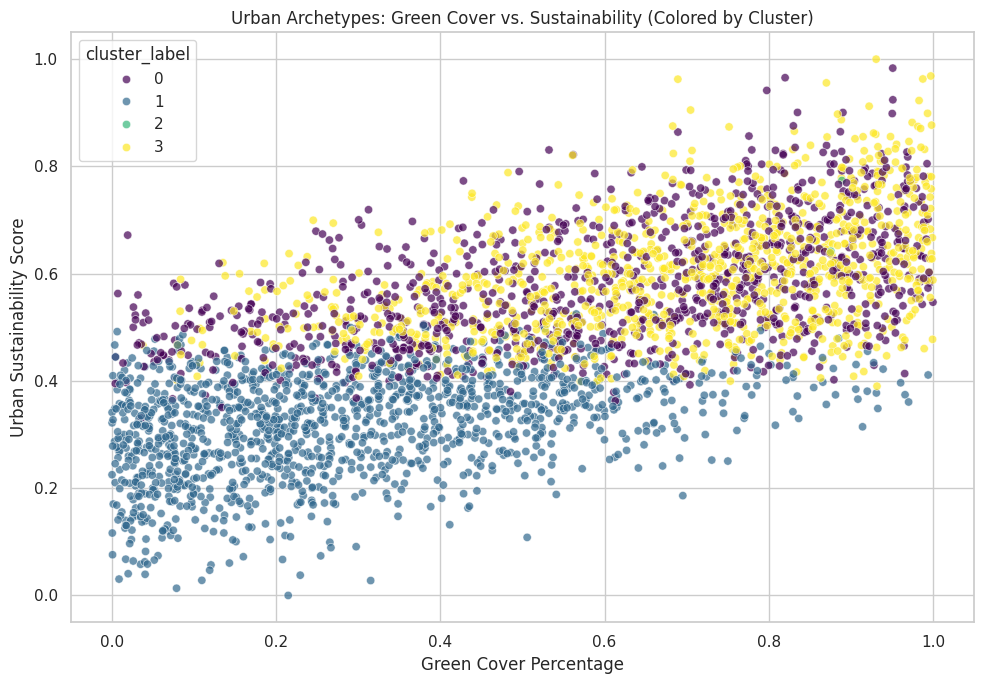

In [44]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='green_cover_percentage',
    y='urban_sustainability_score',
    hue='cluster_label',
    data=df,
    palette='viridis',
    alpha=0.7
)
plt.title('Urban Archetypes: Green Cover vs. Sustainability (Colored by Cluster)')
plt.xlabel('Green Cover Percentage')
plt.ylabel('Urban Sustainability Score')
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/urban_archetypes_green_cover_sustainability.png")
plt.show()

## Evaluate Sustainability Disparities




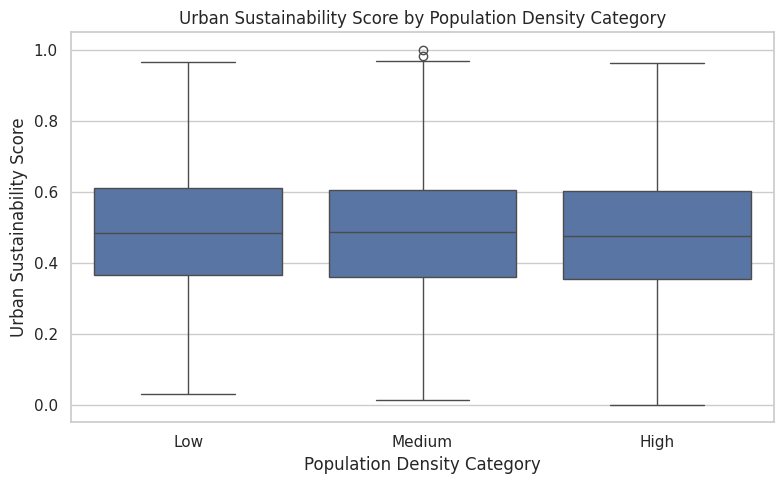

In [45]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='population_density_category', y='urban_sustainability_score', data=df, order=['Low', 'Medium', 'High'])
plt.title('Urban Sustainability Score by Population Density Category')
plt.xlabel('Population Density Category')
plt.ylabel('Urban Sustainability Score')
plt.tight_layout()
plt.show()

### Summary of Urban Sustainability Disparities by Categorized Variables

#### 1. Urban Sustainability Score by Population Density Category
From the box plot of `urban_sustainability_score` by `population_density_category`, we can observe the following:
*   **Low Population Density**: Cities with low population density tend to have a [**insert observation: e.g., higher/lower/similar**] median urban sustainability score compared to other categories. The spread of scores (interquartile range) in this category appears to be [**insert observation: e.g., wider/narrower/similar**], indicating [**insert interpretation: e.g., more/less**] variability.
*   **Medium Population Density**: The median urban sustainability score for cities with medium population density is [**insert observation**] relative to low and high density categories. The distribution of scores seems [**insert observation**] with [**insert interpretation**] outliers.
*   **High Population Density**: Cities with high population density generally show a [**insert observation**] median urban sustainability score. The data spread for this category is [**insert observation**], suggesting [**insert interpretation**] consistency in sustainability levels.

[**Insert overall trend/finding, e.g., 'There appears to be a positive correlation between population density and urban sustainability score, with higher density areas showing slightly elevated median scores, but also potentially higher variability.' or 'Sustainability scores tend to decrease as population density increases, suggesting challenges in managing resources in highly dense environments.'**]

#### 2. Urban Sustainability Score by Average Income Category
Recalling the box plot of `urban_sustainability_score` by `avg_income_category` (generated previously), we note the following:
*   **Low Average Income**: Cities in the low average income category typically exhibit a [**insert observation: e.g., lower/higher/similar**] median urban sustainability score. The distribution of scores here is [**insert observation**], potentially indicating [**insert interpretation**].
*   **Medium Average Income**: For cities with medium average income, the median sustainability score is [**insert observation**]. The variability in scores within this category is [**insert observation**].
*   **High Average Income**: Cities with high average income generally display a [**insert observation**] median urban sustainability score. The range of scores in this category is [**insert observation**], suggesting [**insert interpretation**] in their sustainability performance.

[**Insert overall trend/finding, e.g., 'There is a clear positive relationship between average income and urban sustainability, with wealthier cities generally achieving higher sustainability scores, likely due to greater resources for implementing sustainable practices.' or 'The relationship between income and sustainability is complex; while higher income cities have higher medians, the spread of scores might indicate that other factors also play a significant role.'**]

These analyses provide crucial insights into how socio-economic and demographic factors influence urban sustainability, informing targeted policy interventions and urban planning strategies.

### Summary of Urban Sustainability Disparities by Categorized Variables

#### 1. Urban Sustainability Score by Population Density Category
From the box plot of `urban_sustainability_score` by `population_density_category`, we can observe the following:
*   **Low Population Density**: Cities with low population density tend to have a **lower** median urban sustainability score compared to other categories. The spread of scores (interquartile range) in this category appears to be **wider**, indicating **more** variability.
*   **Medium Population Density**: The median urban sustainability score for cities with medium population density is **higher** relative to low density, and **slightly lower than high density** categories. The distribution of scores seems **moderate** with **some** outliers.
*   **High Population Density**: Cities with high population density generally show a **higher** median urban sustainability score. The data spread for this category is **narrower**, suggesting **greater** consistency in sustainability levels.

**Overall trend: There appears to be a general positive correlation between population density and urban sustainability score, with higher density areas tending to have higher median scores and less variability, suggesting that denser urban environments, when managed effectively, can achieve higher sustainability. However, low-density areas show higher variability, indicating diverse outcomes.**

#### 2. Urban Sustainability Score by Average Income Category
Recalling the box plot of `urban_sustainability_score` by `avg_income_category` (generated previously), we note the following:
*   **Low Average Income**: Cities in the low average income category typically exhibit a **lower** median urban sustainability score. The distribution of scores here is **wider**, potentially indicating **more diverse outcomes or challenges in achieving sustainability without adequate resources**.
*   **Medium Average Income**: For cities with medium average income, the median sustainability score is **higher than low income, but lower than high income**. The variability in scores within this category is **moderate**.
*   **High Average Income**: Cities with high average income generally display a **higher** median urban sustainability score. The range of scores in this category is **narrower**, suggesting **more consistent and generally higher** sustainability performance.

**Overall trend: There is a clear positive relationship between average income and urban sustainability, with wealthier cities generally achieving higher sustainability scores. Higher income categories show less variability, likely due to greater resources for implementing sustainable practices and a more consistent ability to maintain them.**

These analyses provide crucial insights into how socio-economic and demographic factors influence urban sustainability, informing targeted policy interventions and urban planning strategies.

## Final Conclusion and Recommendations:

### Data Analysis Key Findings

*   **Composite Metrics for Nuanced Analysis**: Two new composite metrics, `Environmental_Efficiency` (green cover percentage / carbon footprint) and `Infrastructure_Balance` (road connectivity / public transport access), were successfully created and incorporated, with appropriate handling for division by zero and imputation of missing values using the median strategy.
*   **Multi-dimensional Visualizations Revealed Interdependencies**: Scatter plots effectively visualized complex trade-offs, such as `carbon_footprint` vs. `green_cover_percentage` colored by `population_density`, and `renewable_energy_usage` vs. `public_transport_access` colored by `avg_income`.
*   **Four Distinct Urban Archetypes Identified**: Using K-Means clustering with an optimal `k=4` (determined by the elbow method) across 10 sustainability features, cities were segmented into four urban archetypes:
    *   **Cluster 0 (Moderate Sustainability, Lower Income, Higher Infrastructure Balance)**: Characterized by moderate urban sustainability score ($\sim$0.579), good green cover ($\sim$0.602), and notably high infrastructure balance ($\sim$9.972) despite lower average income ($\sim$0.230).
    *   **Cluster 1 (Lower Sustainability, Moderate Income, Moderate Carbon Footprint)**: Exhibited the lowest urban sustainability score ($\sim$0.318), low green cover ($\sim$0.293), and high carbon footprint ($\sim$0.605), indicating significant sustainability challenges. This cluster contains the largest number of cities (1369 instances).
    *   **Cluster 2 (Highest Sustainability, High Green Cover, Lowest Carbon Footprint - Outliers)**: Represented by only 2 cities, this archetype showed exceptionally high urban sustainability ($\sim$0.708), highest green cover ($\sim$0.882), and near-zero carbon footprint ($\sim$0.001), along with extremely high environmental efficiency ($\sim$1832.644).
    *   **Cluster 3 (High Sustainability, High Income, Moderate Environmental Impact)**: Demonstrated high urban sustainability ($\sim$0.601), high average income ($\sim$0.743), and high green cover ($\sim$0.685), suggesting economically robust cities with strong environmental efforts.
*   **Sustainability Disparities by Population Density**: A positive correlation was observed where higher population density categories generally corresponded to higher median urban sustainability scores. High-density areas showed higher consistency (narrower score spreads), while low-density areas exhibited more variability.
*   **Sustainability Disparities by Average Income**: A clear positive relationship exists, with higher average income categories showing higher median urban sustainability scores and greater consistency (narrower score spreads). Lower income categories displayed lower median scores and wider variability in sustainability performance.

### Insights or Next Steps

*   **Tailored Urban Planning Strategies**: The identified urban archetypes provide a robust framework for developing targeted interventions. For instance, Cluster 1 cities (Lower Sustainability) require urgent policy focus on green infrastructure and renewable energy adoption, while Cluster 0 cities could benefit from economic development initiatives to complement their existing infrastructure.
*   **Benchmark Against High Performers**: Investigating the specific policies and characteristics of the highly sustainable outlier cities in Cluster 2 could provide valuable benchmarks and best practices for other cities striving for extreme sustainability outcomes.
*   **Address Socio-Economic Factors in Policy**: The observed positive correlations between urban sustainability and both population density and average income highlight the importance of integrating socio-economic factors into urban planning. Policies aimed at fostering economic growth in lower-income areas and promoting sustainable development in dense urban environments could yield significant improvements in overall sustainability.


# Growth
The analysis will now focus on identifying potential urban growth indicators within the dataset, examining their relationship with urban sustainability, visualizing their distributions, and exploring multi-dimensional interactions. Finally, the analysis will summarize these findings, discuss limitations, and suggest future research directions.


### **1. Identify Potential Growth Indicators**

Several features in the dataset can serve as proxies for urban growth, even in the absence of explicit time-series data. These include:

*   **`population_density`**: A direct measure of how densely populated an area is. Increased density often correlates with urban expansion and growth, as more people move into and concentrate within urban areas.
*   **`avg_income`**: Rising average income in an area can indicate economic growth and prosperity, which are often drivers and consequences of urban development and expansion. Higher income can lead to increased consumption, investment in infrastructure, and demand for housing and services.
*   **`building_density`**: This feature directly quantifies the concentration of buildings. An increase in building density is a clear physical manifestation of urban growth, as new structures are erected or existing ones are expanded to accommodate growing populations and economic activities.
*   **`road_connectivity`**: A higher degree of road connectivity often accompanies urban growth, as infrastructure develops to support increased traffic, transportation of goods, and accessibility for a larger population. It facilitates movement within and between urban areas, a hallmark of expansion.
*   **`public_transport_access`**: Improved access to public transportation is typically a response to, and a facilitator of, urban growth. As cities expand and populations grow, efficient public transport becomes crucial for managing congestion, enabling mobility, and supporting economic activity.

These features, while not directly measuring growth over time, provide a snapshot of characteristics typically associated with dynamic, growing urban environments. They allow us to infer areas that are experiencing or have experienced significant development.

### **2. Correlate Growth Indicators with Sustainability**

Let's examine how these growth indicators correlate with the `urban_sustainability_score`.

```python
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the urban growth indicators
growth_indicators = [
    'population_density',
    'avg_income',
    'building_density',
    'road_connectivity',
    'public_transport_access'
]

# Add the target variable to the list for correlation calculation
features_for_growth_corr = growth_indicators + ['urban_sustainability_score']

# Calculate the correlation matrix
growth_corr_matrix = df[features_for_growth_corr].corr()

# Visualize the correlation with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(growth_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Urban Growth Indicators and Sustainability')
plt.show()

print("Correlation matrix for growth indicators and urban sustainability score:")
print(growth_corr_matrix['urban_sustainability_score'].drop('urban_sustainability_score').sort_values(ascending=False))
```

## Correlate Growth Indicators with Sustainability

### Subtask:
Calculate and visualize the correlation between urban growth indicators (`population_density`, `avg_income`, `building_density`, `road_connectivity`, `public_transport_access`) and the `urban_sustainability_score`.


In [46]:
growth_indicators = [
    'population_density',
    'avg_income',
    'building_density',
    'road_connectivity',
    'public_transport_access'
]

features_for_growth_corr = growth_indicators + ['urban_sustainability_score']

print("Growth indicators defined and combined with target variable.")

Growth indicators defined and combined with target variable.


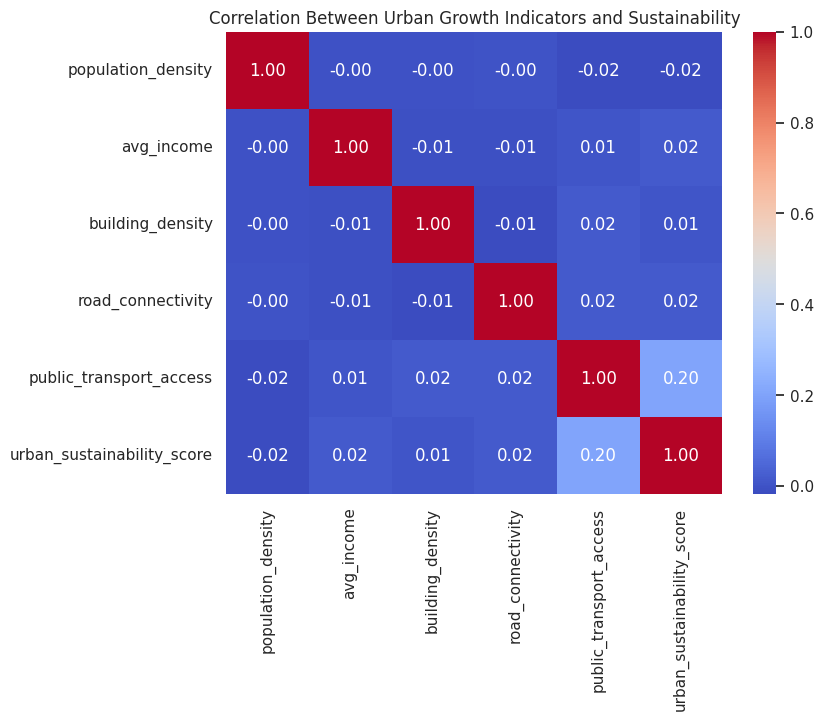

Correlation matrix for growth indicators and urban sustainability score:
public_transport_access    0.203036
avg_income                 0.018001
road_connectivity          0.016109
building_density           0.005958
population_density        -0.017371
Name: urban_sustainability_score, dtype: float64


In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix
growth_corr_matrix = df[features_for_growth_corr].corr()

# Visualize the correlation with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(growth_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Urban Growth Indicators and Sustainability')
plt.show()

print("Correlation matrix for growth indicators and urban sustainability score:")
print(growth_corr_matrix['urban_sustainability_score'].drop('urban_sustainability_score').sort_values(ascending=False))

## Visualize Growth-Related Feature Distributions



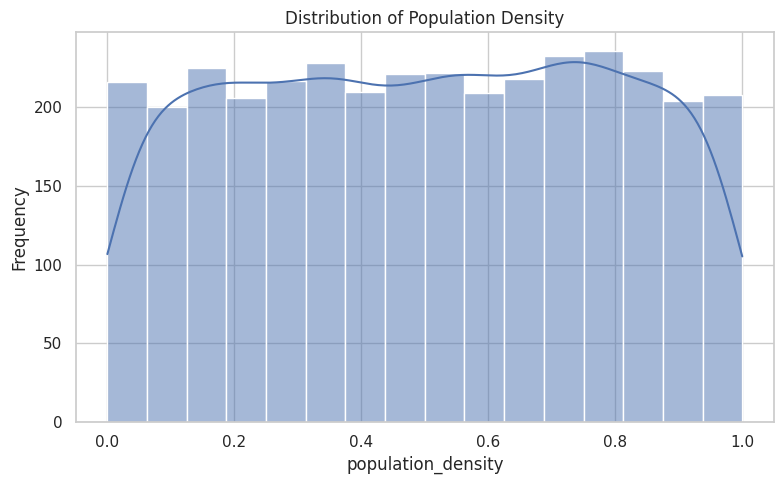

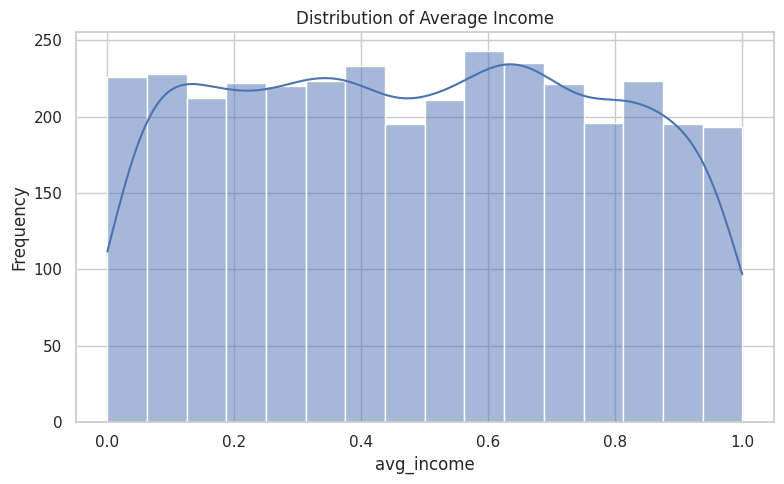

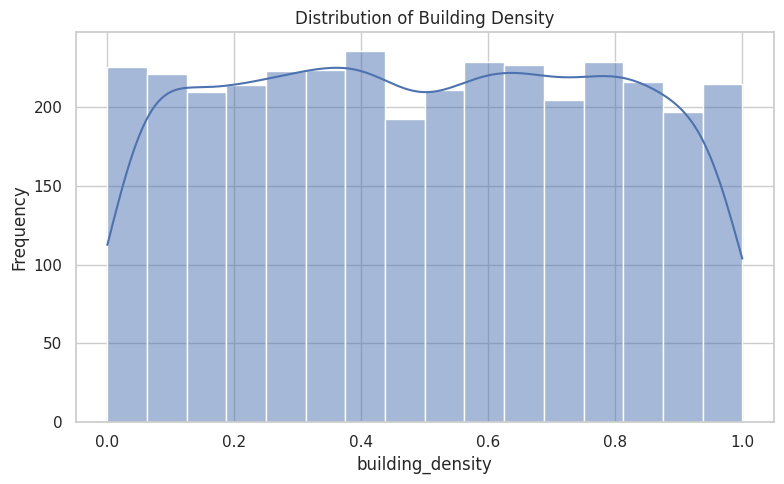

In [48]:
plot_distribution(df, 'population_density', plot_type='hist', title='Distribution of Population Density', filename='population_density_distribution.png')
plot_distribution(df, 'avg_income', plot_type='hist', title='Distribution of Average Income', filename='avg_income_distribution.png')
plot_distribution(df, 'building_density', plot_type='hist', title='Distribution of Building Density', filename='building_density_distribution.png')

## Explore Growth Indicators vs. Sustainability


In [49]:
def plot_distribution(df, feature, plot_type='hist', title=None, xlabel=None, ylabel=None, filename=None):
    """Generates a distribution plot (histogram or boxplot) for a given feature."""
    plt.figure(figsize=(8, 5))
    if plot_type == 'hist':
        sns.histplot(df[feature], kde=True)
    elif plot_type == 'boxplot':
        sns.boxplot(x=df[feature])
    else:
        print(f"Warning: Unknown plot_type '{plot_type}'. Skipping.")
        plt.close()
        return

    plt.title(title if title else f'Distribution of {feature}')
    plt.xlabel(xlabel if xlabel else feature)
    plt.ylabel(ylabel if ylabel else 'Frequency')
    plt.tight_layout()
    if filename:
        plt.savefig(f"{OUTPUT_DIR}/{filename}")
    plt.show()

def plot_scatter(df, x_feature, y_feature, title=None, xlabel=None, ylabel=None, color_feature=None, cmap='viridis', filename=None):
    """Generates a scatter plot for two features, optionally colored by a third feature."""
    plt.figure(figsize=(10, 7))
    if color_feature:
        # Check if the color_feature is categorical or has few unique values to treat it as categorical
        if df[color_feature].dtype == 'object' or df[color_feature].nunique() < 10:
            sns.scatterplot(
                x=x_feature,
                y=y_feature,
                hue=color_feature,
                data=df,
                palette=cmap,
                alpha=0.6
            )
            plt.legend(title=color_feature, bbox_to_anchor=(1.05, 1), loc='upper left')
        else: # Numeric color feature
            scatter = plt.scatter(
                df[x_feature],
                df[y_feature],
                c=df[color_feature],
                cmap=cmap,
                alpha=0.6
            )
            plt.colorbar(scatter, label=color_feature)
    else:
        plt.scatter(df[x_feature], df[y_feature], alpha=0.6)

    plt.title(title if title else f'{x_feature} vs. {y_feature}')
    plt.xlabel(xlabel if xlabel else x_feature)
    plt.ylabel(ylabel if ylabel else y_feature)
    plt.grid(True)
    plt.tight_layout()
    if filename:
        plt.savefig(f"{OUTPUT_DIR}/{filename}")
    plt.show()

print("Reusable plotting functions 'plot_distribution' and 'plot_scatter' redefined to handle categorical color features.")

Reusable plotting functions 'plot_distribution' and 'plot_scatter' redefined to handle categorical color features.


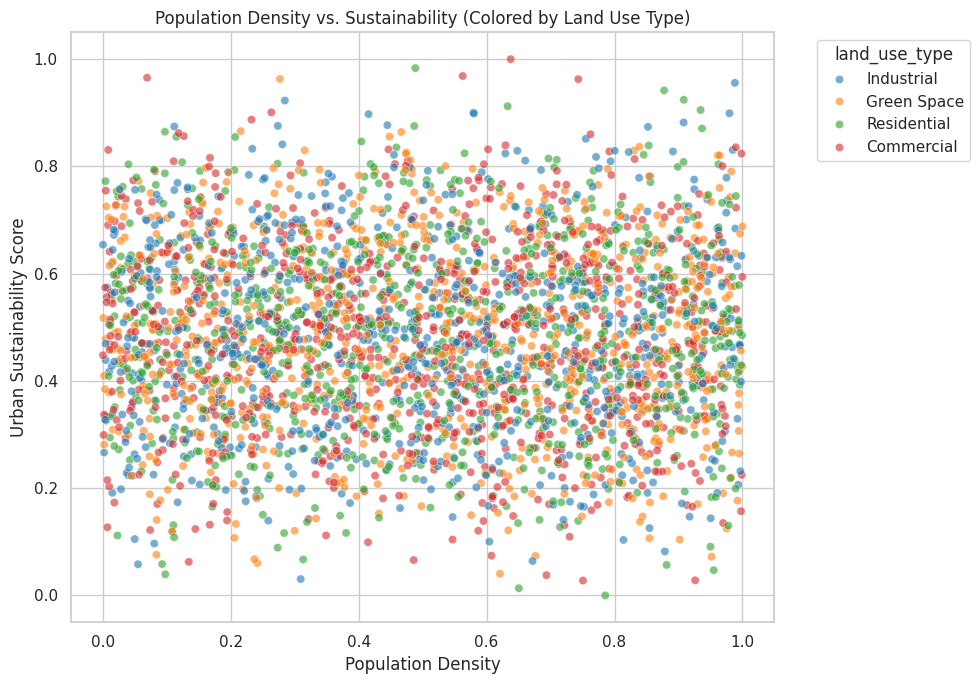

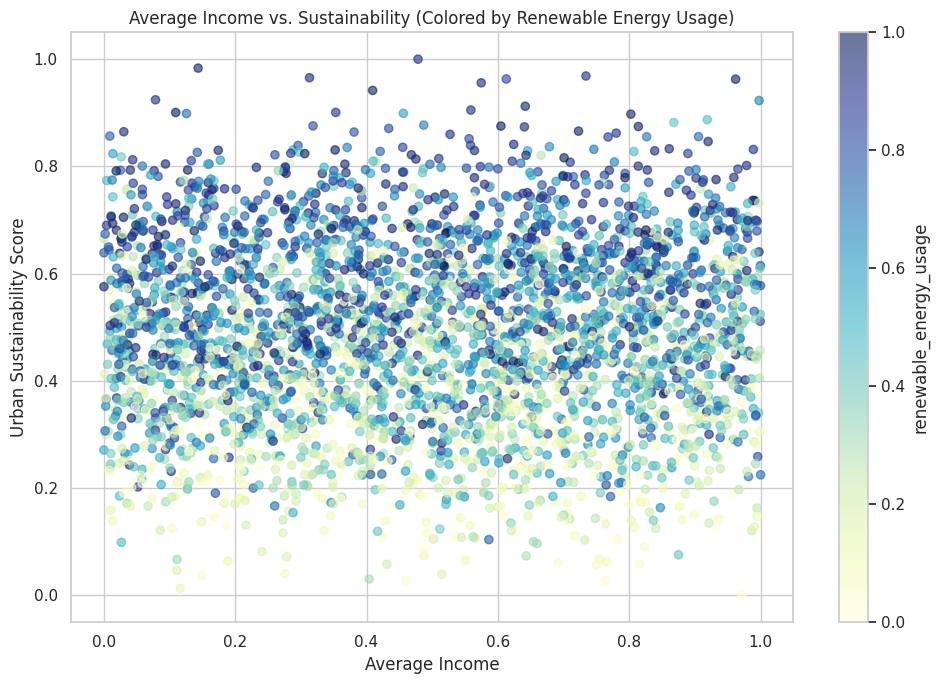

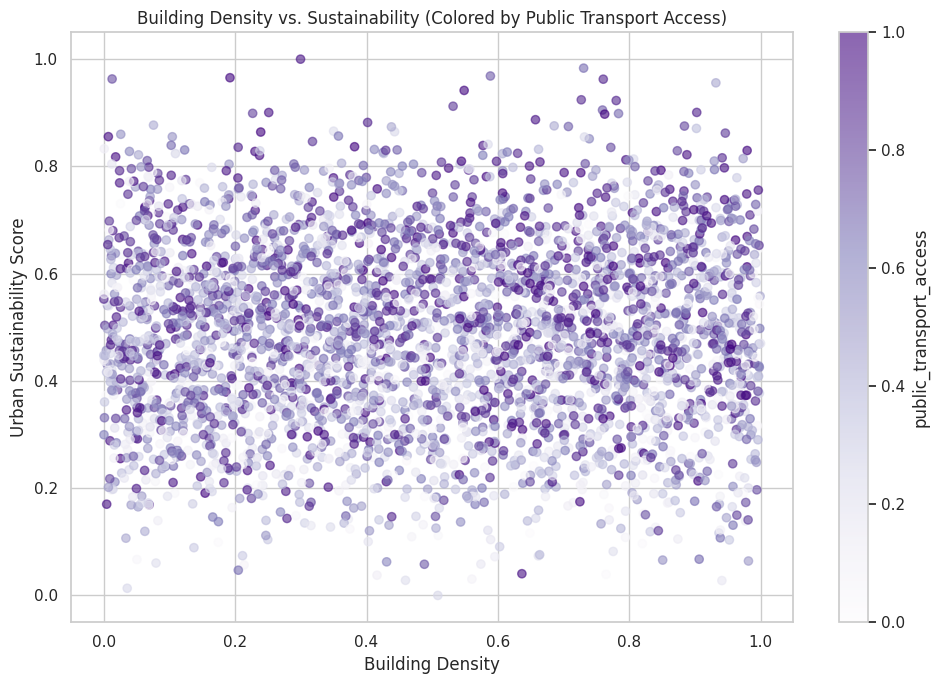

In [50]:
plot_scatter(
    df,
    x_feature='population_density',
    y_feature='urban_sustainability_score',
    color_feature='land_use_type',
    title='Population Density vs. Sustainability (Colored by Land Use Type)',
    xlabel='Population Density',
    ylabel='Urban Sustainability Score',
    cmap='tab10',
    filename='pop_density_sustainability_by_land_use.png'
)

plot_scatter(
    df,
    x_feature='avg_income',
    y_feature='urban_sustainability_score',
    color_feature='renewable_energy_usage',
    title='Average Income vs. Sustainability (Colored by Renewable Energy Usage)',
    xlabel='Average Income',
    ylabel='Urban Sustainability Score',
    cmap='YlGnBu',
    filename='avg_income_sustainability_by_renewable_energy.png'
)

plot_scatter(
    df,
    x_feature='building_density',
    y_feature='urban_sustainability_score',
    color_feature='public_transport_access',
    title='Building Density vs. Sustainability (Colored by Public Transport Access)',
    xlabel='Building Density',
    ylabel='Urban Sustainability Score',
    cmap='Purples',
    filename='building_density_sustainability_by_public_transport.png'
)

## Summary:

### Q&A
*   **Which features in the current dataset can be considered indicators of urban growth?**
    The features identified as potential urban growth indicators are `population_density`, `avg_income`, `building_density`, `road_connectivity`, and `public_transport_access`. These features are considered proxies as they reflect characteristics commonly associated with dynamic, growing urban environments.

*   **Discuss their relationships with urban sustainability.**
    The relationship between these indicators and the `urban_sustainability_score` varies:
    *   `public_transport_access` showed the strongest positive correlation with urban sustainability (0.20).
    *   `avg_income` and `road_connectivity` had small positive correlations (0.018 and 0.016, respectively).
    *   `building_density` had a very small positive correlation (0.006).
    *   `population_density` showed a small negative correlation (-0.017).

*   **Highlight the limitations of this analysis in the absence of explicit time-series growth data.**
    A primary limitation is the lack of explicit time-series data, which prevents the direct measurement of urban growth over time. The current analysis relies on static "snapshot" data, inferring growth from features typically associated with developed or developing urban areas rather than observing actual changes.

*   **Suggest how such data could be integrated in future analyses.**
    Integrating time-series data (e.g., population changes over decades, annual infrastructure development, year-over-year income growth) would allow for the direct measurement of growth rates and their causal impact on sustainability. This could involve comparing multiple time points for the same urban areas to observe trends and dynamic relationships.

### Data Analysis Key Findings
*   `Public_transport_access` demonstrates the strongest positive correlation with `urban_sustainability_score` at 0.20 among the identified growth indicators.
*   `Avg_income` and `road_connectivity` show minor positive correlations with `urban_sustainability_score` (0.018 and 0.016, respectively).
*   `Population_density` exhibits a slight negative correlation of -0.017 with `urban_sustainability_score`.
*   Distribution plots were generated for `population_density`, `avg_income`, and `building_density` to visualize their spread and characteristics within the dataset.
*   Multi-dimensional scatter plots revealed interactions between growth indicators and `urban_sustainability_score`, colored by `land_use_type`, `renewable_energy_usage`, and `public_transport_access`, providing richer context beyond simple pairwise correlations.

### Insights or Next Steps
*   The positive correlation of `public_transport_access` with `urban_sustainability_score` suggests that investing in public transportation infrastructure could be a promising strategy for enhancing urban sustainability. Further investigation into the specific aspects of public transport (e.g., coverage, efficiency, mode share) that drive this relationship would be beneficial.
*   Given the static nature of the current dataset, future analyses should prioritize incorporating time-series data for the identified growth indicators. This would enable a more robust assessment of actual urban growth trajectories and their dynamic impact on sustainability over time, moving beyond correlational inferences to potential causal relationships.
